# Compare the performance of the model trained on augmented data (basic) and raw data : PAMAP2

2024.10.09. ~ 2024.11.02.<br>
Gyuyeon Lim (lky473736) 

<br>

- **Reference**
    - https://github.com/uchidalab/time_series_augmentation/blob/master/utils/augmentation.py
    - https://github.com/terryum/Data-Augmentation-For-Wearable-Sensor-Data/blob/master/Example_DataAugmentation_TimeseriesData.ipynb
    - https://pypi.org/project/transform3d/
    - http://dmqm.korea.ac.kr/activity/seminar/390
    - https://hyeongyuu.github.io/machine%20learning/Augmentation_timeseries/
    
<br>

- **addition library**
    - GPUtil
    - memory_profiler
    - transforms3d
    
<br>

### Abstract 

This study evaluates the impact of data augmentation techniques on the performance of machine learning models trained on the PAMAP2 dataset. Specifically, we compare models trained on raw data and those trained on data enhanced through basic augmentation methods such as **Jitter**, **Scaling**, **Magnitude Warp**, **Time Warp**, **Random Guided Warp**, **Window Slice**, and **Window Warp**. These augmentation techniques aim to address class imbalance and enhance model robustness by generating diverse patterns from the original time-series data. The objective is to assess whether these transformations can improve model accuracy and generalization, ultimately providing insights into the efficacy of data augmentation for time-series classification tasks.


- **Data**
    - PAMAP2 dataset : https://archive.ics.uci.edu/dataset/231/pamap2+physical+activity+monitoring
    - data abstract : The PAMAP2 Physical Activity Monitoring dataset contains data of 18 different physical activities (such as walking, cycling, playing soccer, etc.), performed by 9 subjects wearing 3 inertial measurement units and a heart rate monitor. The dataset can be used for activity recognition and intensity estimation, while developing and applying algorithms of data processing, segmentation, feature extraction and classification.

    - window size : 100 (will use way of sliding window)

- **Model**
    - CNN-LSTM
    - U-net
    - transformer-encoder

- **Way of Augmentation**
    - **Jitter**: Adds noise to the input data to generate augmented data.
    - **Scaling**: Scales the input data by a random factor to create augmented data.
    - **Magnitude Warp**: Smoothly distorts certain points of the input data to generate augmented data.
    - **Time Warp**: Warps the time axis to create new data.
    - **Random Guided Warp**: Uses DTW or ShapeDTW to select a random pattern within the same class and applies warping.
    - **Window Slice**: Randomly selects a segment of the data and reduces it.
    - **Window Warp**: Stretches or compresses specific segments to create new patterns.
    
---

### Environment and importing libraries


In [1]:
import psutil
import platform
import GPUtil

# System and CPU information
system = platform.system()
processor = platform.processor()

cpu_count = psutil.cpu_count(logical=True)
cpu_usage = psutil.cpu_percent(interval=1)
virtual_memory = psutil.virtual_memory()

print(f"System: {system}")
print(f"Processor: {processor}")
print(f"CPU Cores: {cpu_count}")
print(f"CPU Usage: {cpu_usage}%")
print(f"Total RAM: {virtual_memory.total / (1024**3):.2f} GB")
print(f"Available RAM: {virtual_memory.available / (1024**3):.2f} GB")
print(f"RAM Usage: {virtual_memory.percent}%")

# GPU information
gpus = GPUtil.getGPUs()
if gpus:
    for gpu in gpus:
        print(f"\nGPU {gpu.id}: {gpu.name}")
        print(f"  Load: {gpu.load * 100:.1f}%")
        print(f"  Free Memory: {gpu.memoryFree / 1024:.2f} GB")
        print(f"  Used Memory: {gpu.memoryUsed / 1024:.2f} GB")
        print(f"  Total Memory: {gpu.memoryTotal / 1024:.2f} GB")
        print(f"  Temperature: {gpu.temperature} °C")
else:
    print("\nNo GPU found.")


System: Linux
Processor: x86_64
CPU Cores: 16
CPU Usage: 19.7%
Total RAM: 1039.13 GB
Available RAM: 996.47 GB
RAM Usage: 4.1%

GPU 0: CUDA GPU
  Load: nan%
  Free Memory: 39.95 GB
  Used Memory: 0.05 GB
  Total Memory: 40.00 GB
  Temperature: 29.0 °C


In [2]:
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
from scipy.stats import skew
import os
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import numpy as np
import scipy
from tqdm import tqdm
from scipy.interpolate import CubicSpline

2024-11-02 06:57:54.844780: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9360] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-02 06:57:54.844850: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-02 06:57:54.844882: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1537] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-02 06:57:54.853801: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# cnn model vary kernel size
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from keras.utils import to_categorical

import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape, LSTM, Conv1D, MaxPooling1D
from tensorflow.keras.layers import TimeDistributed, Conv1D, MaxPooling1D


In [4]:
# ignoring future warnings
import warnings
warnings.simplefilter('ignore')

In [5]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

-----

### data load, preprocessing


In [6]:
# column names of the data

columns = ['time_stamp', 'activity_id', 'heart_rate', 'hand_temperature', 'hand_3D_acceleration_16_x',  'hand_3D_acceleration_16_y',
         'hand_3D_acceleration_16_z', 'hand_3D_acceleration_6_x', 'hand_3D_acceleration_6_y', 'hand_3D_acceleration_6_z', 'hand_3D_gyroscope_x',
         'hand_3D_gyroscope_y',  'hand_3D_gyroscope_z', 'hand_3D_magnetometer_x', 'hand_3D_magnetometer_y', 'hand_3D_magnetometer_z',
         'hand_4D_orientation_x', 'hand_4D_orientation_y', 'hand_4D_orientation_z', 'hand_4D_orientation_w', 'chest_temperature', 'chest_3D_acceleration_16_x',
         'chest_3D_acceleration_16_y', 'chest_3D_acceleration_16_z', 'chest_3D_acceleration_6_x', 'chest_3D_acceleration_6_y',  'chest_3D_acceleration_6_z',
         'chest_3D_gyroscope_x', 'chest_3D_gyroscope_y', 'chest_3D_gyroscope_z', 'chest_3D_magnetometer_x', 'chest_3D_magnetometer_y',
         'chest_3D_magnetometer_z', 'chest_4D_orientation_x', 'chest_4D_orientation_y', 'chest_4D_orientation_z', 'chest_4D_orientation_w',
         'ankle_temperature', 'ankle_3D_acceleration_16_x', 'ankle_3D_acceleration_16_y', 'ankle_3D_acceleration_16_z', 'ankle_3D_acceleration_6_x',
         'ankle_3D_acceleration_6_y', 'ankle_3D_acceleration_6_z', 'ankle_3D_gyroscope_x', 'ankle_3D_gyroscope_y', 'ankle_3D_gyroscope_z',
         'ankle_3D_magnetometer_x', 'ankle_3D_magnetometer_y', 'ankle_3D_magnetometer_z', 'ankle_4D_orientation_x', 'ankle_4D_orientation_y',
         'ankle_4D_orientation_z', 'ankle_4D_orientation_w']

In [7]:
# data load

def load_data() :
    root = os.path.join('..', '..', '..', 'data', 'PAMAP', 'PAMAP')
    data_list = []  
    
    for i in range(101, 110) : 
        path = os.path.join(root, f"{i}.dat")
        df = pd.read_table(path, header=None, sep='\s+')
        
        print (f"{i}.dat is {df.shape}")
        
        df.columns = columns
        df['id'] = i
        
        print (f"{len(df['activity_id'].unique())}")
        
#         if (len(df['activity_id'].unique()) != 13) :
#             print ("no 13 activity in here. this won't be in completion df")
#             pass
               
#         else : 
        data_list.append(df)  

    #  data = pd.concat(data_list, ignore_index=True)
    # data.reset_index(drop=True, inplace=True)
    
    return data_list

df_list = load_data()

101.dat is (376417, 54)
13
102.dat is (447000, 54)
13
103.dat is (252833, 54)
9
104.dat is (329576, 54)
12
105.dat is (374783, 54)
13
106.dat is (361817, 54)
13
107.dat is (313599, 54)
12
108.dat is (408031, 54)
13
109.dat is (8477, 54)
2


In [8]:
# concatenation the dataframe

df = pd.concat(df_list, ignore_index=True)
df.reset_index(drop=True, inplace=True)

df

time_stamp  activity_id  heart_rate  hand_temperature  \
0              8.38            0       104.0           30.0000   
1              8.39            0         NaN           30.0000   
2              8.40            0         NaN           30.0000   
3              8.41            0         NaN           30.0000   
4              8.42            0         NaN           30.0000   
...             ...          ...         ...               ...   
2872528      100.19            0         NaN           25.1875   
2872529      100.20            0         NaN           25.1875   
2872530      100.21            0         NaN           25.1875   
2872531      100.22            0         NaN           25.1875   
2872532      100.23            0       161.0           25.1875   

         hand_3D_acceleration_16_x  hand_3D_acceleration_16_y  \
0                          2.37223                    8.60074   
1                          2.18837                    8.56560   
2                          2.37357                    8.60107   
3                          2.07473                    8.52853   
4                          2.22936                    8.83122   
...                            ...                        ...   
2872528                   -4.71493                   10.22250   
2872529                   -4.95932                   10.37130   
2872530                   -4.93997                    9.83615   
2872531                   -4.64941                    9.11129   
2872532                   -4.09726                    8.15642   

         hand_3D_acceleration_16_z  hand_3D_acceleration_6_x  \
0                          3.51048                   2.43954   
1                          3.66179                   2.39494   
2                          3.54898                   2.30514   
3                          3.66021                   2.33528   
4                          3.70000                   2.23055   
...                            ...                       ...   
2872528                    4.66893                  -5.04654   
2872529                    4.12594                  -4.96890   
2872530                    3.70468                  -5.04613   
2872531                    3.51904                  -5.06854   
2872532                    3.29961                  -4.73244   

         hand_3D_acceleration_6_y  hand_3D_acceleration_6_z  ...  \
0                         8.76165                   3.35465  ...   
1                         8.55081                   3.64207  ...   
2                         8.53644                   3.73280  ...   
3                         8.53622                   3.73277  ...   
4                         8.59741                   3.76295  ...   
...                           ...                       ...  ...   
2872528                   9.94944                   4.50736  ...   
2872529                  10.29620                   4.43102  ...   
2872530                  10.35690                   4.14405  ...   
2872531                   9.75268                   3.87359  ...   
2872532                   8.82870                   3.54305  ...   

         ankle_3D_gyroscope_y  ankle_3D_gyroscope_z  ankle_3D_magnetometer_x  \
0                    0.009250             -0.017580                 -61.1888   
1                   -0.004638              0.000368                 -59.8479   
2                    0.000148              0.022495                 -60.7361   
3                   -0.020301              0.011275                 -60.4091   
4                   -0.014303             -0.002823                 -61.5199   
...                       ...                   ...                      ...   
2872528             -0.062676             -0.127084                 -46.5153   
2872529             -0.027006             -0.089808                 -45.7474   
2872530             -0.038024             -0.064709                 -46.3997   
2872531             -0.025796             -0.0643

In [9]:
# A function that checks the percentage of missing values,unique values,percentage of one catagory values and type against each column.

'''
    Unique_values : the component that not null
    Missing values : null
    Peercentage of Missing values : number of null / number of all samples
    Data Type : dtype of each cols
'''

def statistics(df):
    stats = []
    for col in df.columns:
        stats.append((col, df[col].nunique(), df[col].isnull().sum(), df[col].isnull().sum() * 100 / df.shape[0], df[col].dtype))

    stats_df = pd.DataFrame(stats, columns=['Feature', 'Unique_values', 'Missing values', 'Percentage of Missing Values', 'Data Type'])
    stats_df.set_index('Feature', drop=True, inplace=True)
    stats_df.drop(stats_df[stats_df['Missing values'] == 0].index, axis=0, inplace=True)
    stats_df.sort_values('Percentage of Missing Values', ascending=False, inplace=True)
    return stats_df

statistics(df).T

Feature                      heart_rate hand_3D_gyroscope_z hand_temperature  \
Unique_values                       146             1875844              138   
Missing values                  2610265               13141            13141   
Percentage of Missing Values    90.8698            0.457471         0.457471   
Data Type                       float64             float64          float64   

Feature                      hand_4D_orientation_z hand_4D_orientation_y  \
Unique_values                              1247500               1347718   
Missing values                               13141                 13141   
Percentage of Missing Values              0.457471              0.457471   
Data Type                                  float64               float64   

Feature                      hand_4D_orientation_x hand_3D_magnetometer_z  \
Unique_values                              1002405                1130762   
Missing values                               13141                  13141   
Percentage of Missing Values              0.457471               0.457471   
Data Type                                  float64                float64   

Feature                      hand_3D_magnetometer_y hand_3D_magnetometer_x  \
Unique_values                               1220419                1156337   
Missing values                                13141                  13141   
Percentage of Missing Values               0.457471               0.457471   
Data Type                                   float64                float64   

Feature                      hand_4D_orientation_w  ...  \
Unique_values                              1400053  ...   
Missing values                               13141  ...   
Percentage of Missing Values              0.457471  ...   
Data Type                                  float64  ...   

Feature                      chest_3D_acceleration_6_y chest_3D_gyroscope_x  \
Unique_values                                   763044              1827061   
Missing values                                    3563                 3563   
Percentage of Missing Values                  0.124037             0.124037   
Data Type                                      float64              float64   

Feature                      chest_4D_orientation_z chest_3D_gyroscope_z  \
Unique_values                               1449428              1802080   
Missing values                                 3563                 3563   
Percentage of Missing Values               0.124037             0.124037   
Data Type                                   float64              float64   

Feature                      chest_3D_magnetometer_x chest_3D_magnetometer_y  \
Unique_values                                1410128                  626338   
Missing values                                  3563                    3563   
Percentage of Missing Values                0.124037                0.124037   
Data Type                                    float64                 float64   

Feature                      chest_3D_magnetometer_z chest_4D_orientation_x  \
Unique_values                                1270492                 849688   
Missing values                                  3563                   3563   
Percentage of Missing Values                0.124037               0.124037   
Data Type                                    float64                float64   

Feature                      chest_4D_orientation_y chest_3D_gyroscope_y  
Unique_values                                951475              1918959  
Missing values                                 3563                 3563  
Percentage of Missing Values               0.124037             0.124037  
Data Type                                   float64              float64  

[4 rows x 52 columns]

In [10]:
# Function that fills the null values with either the mean or median based on a normal test

def fillnull(columns, df=df):
    from scipy.stats import normaltest
    # Iterating Numerical columns
    for i in columns:
        # Finding Normality of feature
        st, p = normaltest(df[i].dropna())

        # Checking if normal or not
        if p > 0.05:
            # Filling with mean if normal
            df[i].fillna(df[i].mean(), inplace=True)
        else:
            # Filling with median if not normal
            df[i].fillna(df[i].median(), inplace=True)
            
# Taking out column names that have null values
num_cols = statistics(df).index

# Applying function
fillnull(num_cols)

In [11]:
# Acitvity_id = 0 is not an valid activity so it should be dropped
df.drop(df[df['activity_id']==0].index, inplace=True, axis=0)

In [12]:
# As it can be seen here there is no null values any longer in the dataframe.
print (df.isnull().sum())
print (~any(df.isnull()))

time_stamp                    0
activity_id                   0
heart_rate                    0
hand_temperature              0
hand_3D_acceleration_16_x     0
hand_3D_acceleration_16_y     0
hand_3D_acceleration_16_z     0
hand_3D_acceleration_6_x      0
hand_3D_acceleration_6_y      0
hand_3D_acceleration_6_z      0
hand_3D_gyroscope_x           0
hand_3D_gyroscope_y           0
hand_3D_gyroscope_z           0
hand_3D_magnetometer_x        0
hand_3D_magnetometer_y        0
hand_3D_magnetometer_z        0
hand_4D_orientation_x         0
hand_4D_orientation_y         0
hand_4D_orientation_z         0
hand_4D_orientation_w         0
chest_temperature             0
chest_3D_acceleration_16_x    0
chest_3D_acceleration_16_y    0
chest_3D_acceleration_16_z    0
chest_3D_acceleration_6_x     0
chest_3D_acceleration_6_y     0
chest_3D_acceleration_6_z     0
chest_3D_gyroscope_x          0
chest_3D_gyroscope_y          0
chest_3D_gyroscope_z          0
chest_3D_magnetometer_x       0
chest_3D

In [13]:
# information of dataframe

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1942872 entries, 2928 to 2872019
Data columns (total 55 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   time_stamp                  float64
 1   activity_id                 int64  
 2   heart_rate                  float64
 3   hand_temperature            float64
 4   hand_3D_acceleration_16_x   float64
 5   hand_3D_acceleration_16_y   float64
 6   hand_3D_acceleration_16_z   float64
 7   hand_3D_acceleration_6_x    float64
 8   hand_3D_acceleration_6_y    float64
 9   hand_3D_acceleration_6_z    float64
 10  hand_3D_gyroscope_x         float64
 11  hand_3D_gyroscope_y         float64
 12  hand_3D_gyroscope_z         float64
 13  hand_3D_magnetometer_x      float64
 14  hand_3D_magnetometer_y      float64
 15  hand_3D_magnetometer_z      float64
 16  hand_4D_orientation_x       float64
 17  hand_4D_orientation_y       float64
 18  hand_4D_orientation_z       float64
 19  hand_4D_orientatio

In [14]:
# delete cols that doesn't need

df = df.drop (['time_stamp', 'id'], axis=1)
df.columns

Index(['activity_id', 'heart_rate', 'hand_temperature',
       'hand_3D_acceleration_16_x', 'hand_3D_acceleration_16_y',
       'hand_3D_acceleration_16_z', 'hand_3D_acceleration_6_x',
       'hand_3D_acceleration_6_y', 'hand_3D_acceleration_6_z',
       'hand_3D_gyroscope_x', 'hand_3D_gyroscope_y', 'hand_3D_gyroscope_z',
       'hand_3D_magnetometer_x', 'hand_3D_magnetometer_y',
       'hand_3D_magnetometer_z', 'hand_4D_orientation_x',
       'hand_4D_orientation_y', 'hand_4D_orientation_z',
       'hand_4D_orientation_w', 'chest_temperature',
       'chest_3D_acceleration_16_x', 'chest_3D_acceleration_16_y',
       'chest_3D_acceleration_16_z', 'chest_3D_acceleration_6_x',
       'chest_3D_acceleration_6_y', 'chest_3D_acceleration_6_z',
       'chest_3D_gyroscope_x', 'chest_3D_gyroscope_y', 'chest_3D_gyroscope_z',
       'chest_3D_magnetometer_x', 'chest_3D_magnetometer_y',
       'chest_3D_magnetometer_z', 'chest_4D_orientation_x',
       'chest_4D_orientation_y', 'chest_4D_orientat

In [15]:
import pandas as pd

def correlation_matrix(df):
    corr = df.corr()

    sorted_corr = corr['activity_id'].abs().sort_values(ascending=False)

    return sorted_corr

sorted_correlations = correlation_matrix(df)

print(sorted_correlations)

activity_id                   1.000000
chest_3D_acceleration_6_z     0.429279
chest_3D_acceleration_16_z    0.428210
ankle_4D_orientation_w        0.337902
chest_4D_orientation_x        0.324685
chest_3D_magnetometer_y       0.298333
chest_3D_magnetometer_z       0.265201
chest_3D_magnetometer_x       0.241262
ankle_3D_magnetometer_z       0.209349
hand_4D_orientation_x         0.207247
ankle_3D_magnetometer_x       0.199028
ankle_temperature             0.196692
hand_3D_magnetometer_y        0.188350
ankle_4D_orientation_y        0.187077
chest_temperature             0.160191
hand_temperature              0.159274
chest_3D_acceleration_16_x    0.149992
chest_3D_acceleration_6_x     0.147551
ankle_3D_acceleration_6_x     0.145586
ankle_3D_acceleration_16_x    0.134114
hand_3D_acceleration_16_x     0.131847
hand_3D_acceleration_6_x      0.131142
hand_3D_acceleration_6_z      0.118543
hand_3D_acceleration_16_z     0.116912
chest_3D_acceleration_16_y    0.105699
hand_4D_orientation_z    

In [16]:
'''
    To reduce the complexity of the model due to too many features, 
    only features related to 'ankle', 'chest', 'heart rate' will be retained.
    because of memory fraction
'''

col_activity_id = df['activity_id']
col_heart_rate = df['heart_rate']

df = df.filter(regex='(ankle|chest)', axis=1) # using regex (ankle or chest)

df['heart_rate'] = col_heart_rate
df['activity_id'] = col_activity_id

In [17]:
# see that target is 0-based

print (df['activity_id'].unique())


'''
    we need to encoding now to 0-based
    (labelencoding)
'''

[ 1  2  3 17 16 12 13  4  7  6  5 24]


'\n    we need to encoding now to 0-based\n    (labelencoding)\n'

In [18]:
# label encoding

from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
df['activity_id'] = encoder.fit_transform(df['activity_id'])

print (df['activity_id'].unique())

[ 0  1  2 10  9  7  8  3  6  5  4 11]


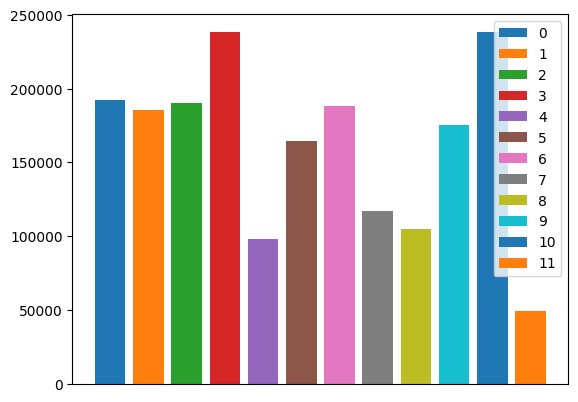

3     238761
10    238690
0     192523
2     189931
6     188107
1     185188
9     175353
5     164600
7     117216
8     104944
4      98199
11     49360
Name: activity_id, dtype: int64


"\n    This situation solved using SMOTE and oversampling random position at records before bunches of documents.\n    But this data is time-series, has depandancy of time.\n    \n    so i will do the original augmentation that Terry Taewoong Um offered. \n    That file will be uploaded at './augmentation'\n"

In [19]:
# activity_id - countplot, value_count

import math

target = np.unique(df['activity_id'])

width = 1
for compo in target : 
    plt.bar(width, len(df[df['activity_id'] == compo]), 
            label=compo)
    width += 1
    
plt.xticks([], [])

plt.legend()
plt.show()

print (df['activity_id'].value_counts())

'''
    This situation solved using SMOTE and oversampling random position at records before bunches of documents.
    But this data is time-series, has depandancy of time.
    
    so i will do the original augmentation that Terry Taewoong Um offered. 
    That file will be uploaded at './augmentation'
'''

In [20]:
# Z-score normalization

from sklearn.preprocessing import StandardScaler

X = df[[feature_name for feature_name in df.columns if feature_name != 'activity_id']]
y = df['activity_id']

SS = StandardScaler()
X = SS.fit_transform(X)

df = pd.DataFrame(data=X, 
                        columns = [feature_name for feature_name in df.columns if feature_name != 'activity_id'])
df['activity_id'] = y.values

df

chest_temperature  chest_3D_acceleration_16_x  \
0                -2.671552                   -0.119921   
1                -2.671552                   -0.076152   
2                -2.671552                   -0.036209   
3                -2.671552                   -0.055467   
4                -2.671552                    0.010843   
...                    ...                         ...   
1942867          -2.546063                   -0.412642   
1942868          -2.546063                   -0.348588   
1942869          -2.546063                   -0.326475   
1942870          -2.546063                   -0.263392   
1942871          -2.546063                   -0.303877   

         chest_3D_acceleration_16_y  chest_3D_acceleration_16_z  \
0                          0.306155                   -0.042085   
1                          0.306108                   -0.041795   
2                          0.321155                   -0.090380   
3                          0.321393                   -0.057974   
4                          0.321372                   -0.049403   
...                             ...                         ...   
1942867                    0.259591                   -0.141467   
1942868                    0.220875                   -0.157180   
1942869                    0.251680                   -0.157136   
1942870                    0.259102                   -0.189275   
1942871                    0.259417                   -0.148879   

         chest_3D_acceleration_6_x  chest_3D_acceleration_6_y  \
0                        -0.031848                   0.321978   
1                        -0.040394                   0.328214   
2                        -0.031419                   0.334419   
3                        -0.014315                   0.331303   
4                        -0.014795                   0.318868   
...                            ...                        ...   
1942867                  -0.441591                   0.275760   
1942868                  -0.459996                   0.225957   
1942869                  -0.381987                   0.216529   
1942870                  -0.346874                   0.232057   
1942871                  -0.303308                   0.250714   

         chest_3D_acceleration_6_z  chest_3D_gyroscope_x  \
0                        -0.073665              0.069143   
1                        -0.073627              0.030607   
2                        -0.060953             -0.015592   
3                        -0.070507              0.026012   
4                        -0.086386             -0.011805   
...                            ...                   ...   
1942867                  -0.196486             -0.340703   
1942868                  -0.209268             -0.204353   
1942869                  -0.193624             -0.062557   
1942870                  -0.180979             -0.051073   
1942871                  -0.184188             -0.031652   

         chest_3D_gyroscope_y  chest_3D_gyroscope_z  ...  \
0                    0.008567             -0.094160  ...   
1                   -0.063867             -0.116397  ...   
2                    0.047400             -0.074207  ...   
3                   -0.106841             -0.164027  ...   
4                   -0.044453             -0.051662  ...   
...                       ...                   ...  ...   
1942867             -0.264536              0.282075  ...   
1942868             -0.282429              0.223975  ...   
1942869             -0.224092              0.335552  ...   
1942870             -0.227636              0.384813  ...   
1942871             -0.242166              0.387094  ...   

         ankle_3D_gyroscope_z  ankle_3D_magnetometer_x  \
0                   -0.002954                -1.612155   
1                   -0.000834                -1.600335   
2                   -0.006259                -1.570259   
3                    0.009598                -1.5934

In [21]:
# input, target split

input_PAMAP = df.drop('activity_id', axis=1)
target_PAMAP = df['activity_id']

input_PAMAP.shape, target_PAMAP.shape

((1942872, 35), (1942872,))

------

### sliding window : split_sequences_freq()

<img src="https://velog.velcdn.com/images/wlwl99/post/e0ebddc2-e075-41e5-bec6-ac424364d1da/image.png" width=400px>

The function above is designed using the **sliding window technique**, but this time the target is determined by **frequency** rather than the last value. Sliding window is a common approach used in two-pointer algorithms, where elements are selected by sliding across the dataset, as illustrated in the earlier figure.

In this function, **`len(sequences)` represents the number of records (rows) in the DataFrame**. The loop iterates through each row, with `i` representing the current row index. `end_ix` is calculated by adding `n_steps` to the current row index, where `n_steps` is the size of the window. Here, the **window slides over the data, selecting a block of rows**.

The loop terminates if `end_ix` exceeds the total number of rows in the DataFrame. Inside the loop, `seq_x` is the input data that selects the rows between the `i`-th and `end_ix - 1`-th row, excluding the last column (target column). `seq_y` is the corresponding target data, which includes the values in the last column for those rows.

Instead of using the last target value as in the previous approach, **the most frequent target class within the window** is selected as the target. This is done using the `Counter` from the `collections` module, which finds the most common class in `seq_y`. Finally, the input data (`X`) and the most frequent class (`y`) are stored for each window.

In [22]:
# sliding window (judging by frequency)

from collections import Counter

def split_sequences_freq(sequences, n_steps, hop=1):
    X, y = list(), list()
    
    # Check if sequences is a DataFrame, convert if necessary
    if not isinstance(sequences, pd.DataFrame):
        sequences = pd.DataFrame(sequences)

    i = 0
    while (i < len(sequences)) : 
        end_ix = i + n_steps

        if end_ix > len(sequences):
            break

        seq_x = sequences.iloc[i:end_ix, :-1].values
        seq_y = sequences.iloc[i:end_ix, -1].values   
        
        # Find the most frequent class in seq_y
        most_frequent_class = Counter(seq_y).most_common(1)[0][0]
        
        X.append(seq_x)
        y.append(int(most_frequent_class))
        
        i += hop

    return np.array(X), np.array(y)

------

### Modeling

In [23]:
# CNN-LSTM

from tensorflow import keras
from tensorflow.keras import layers, regularizers

def build_CNN_LSTM(input_shape, target_size, l2_lambda=0.01):
    model = keras.Sequential()

    # Convolutional layers
    model.add(layers.Conv1D(128, kernel_size=4, padding='same', strides=1, activation='relu', 
                            kernel_regularizer=regularizers.l2(l2_lambda)))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv1D(64, kernel_size=3, padding='same', strides=1, activation='relu', 
                            kernel_regularizer=regularizers.l2(l2_lambda)))
    model.add(layers.Dropout(0.4))

    # LSTM layers
    model.add(layers.LSTM(64, return_sequences=True))
    model.add(layers.LSTM(32, return_sequences=False))
    model.add(layers.Dropout(0.5))

    # Fully connected layers
    model.add(layers.Dense(100, activation='relu', kernel_regularizer=regularizers.l2(l2_lambda)))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(80, activation='relu', kernel_regularizer=regularizers.l2(l2_lambda)))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(60, activation='relu', kernel_regularizer=regularizers.l2(l2_lambda)))
    model.add(layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(l2_lambda)))

    # Output layer
    model.add(layers.Dense(target_size, activation='softmax'))

    return model


In [24]:
from tensorflow.keras import layers, models, regularizers

def build_unet_1d_custom(input_shape, num_classes, l2_lambda=0.01):

    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv1D(64, kernel_size=3, activation='relu', padding='same', 
                       kernel_regularizer=regularizers.l2(l2_lambda))(inputs)
    c1 = layers.Conv1D(64, kernel_size=3, activation='relu', padding='same', 
                       kernel_regularizer=regularizers.l2(l2_lambda))(c1)
    p1 = layers.MaxPooling1D(pool_size=2)(c1)  # Downsampling

    c2 = layers.Conv1D(32, kernel_size=3, activation='relu', padding='same', 
                       kernel_regularizer=regularizers.l2(l2_lambda))(p1)
    c2 = layers.Conv1D(32, kernel_size=3, activation='relu', padding='same', 
                       kernel_regularizer=regularizers.l2(l2_lambda))(c2)
    p2 = layers.MaxPooling1D(pool_size=2)(c2)  # Downsampling

    c3 = layers.Conv1D(16, kernel_size=3, activation='relu', padding='same', 
                       kernel_regularizer=regularizers.l2(l2_lambda))(p2)
    c3 = layers.Conv1D(16, kernel_size=3, activation='relu', padding='same', 
                       kernel_regularizer=regularizers.l2(l2_lambda))(c3)
    p3 = layers.MaxPooling1D(pool_size=2)(c3)  # Downsampling

    # Bottleneck
    b1 = layers.Conv1D(16, kernel_size=3, activation='relu', padding='same', 
                       kernel_regularizer=regularizers.l2(l2_lambda))(p3)
    b1 = layers.Conv1D(16, kernel_size=3, activation='relu', padding='same', 
                       kernel_regularizer=regularizers.l2(l2_lambda))(b1)

    # Decoder
    u3 = layers.Conv1DTranspose(16, kernel_size=2, strides=2, padding='same')(b1)  # Upsampling
    c3_shape = layers.Lambda(lambda x: x[:, :u3.shape[1], :])(c3)  # Adjust shape of c3 to match u3
    u3 = layers.concatenate([u3, c3_shape], axis=-1)  # Concatenate

    c4 = layers.Conv1D(32, kernel_size=3, activation='relu', padding='same')(u3)
    c4 = layers.Conv1D(32, kernel_size=3, activation='relu', padding='same')(c4)

    u4 = layers.Conv1DTranspose(32, kernel_size=2, strides=2, padding='same')(c4)  # Upsampling
    c2_shape = layers.Lambda(lambda x: x[:, :u4.shape[1], :])(c2)  # Adjust shape of c2 to match u4
    u4 = layers.concatenate([u4, c2_shape], axis=-1)  # Concatenate

    c5 = layers.Conv1D(64, kernel_size=3, activation='relu', padding='same')(u4)
    c5 = layers.Conv1D(64, kernel_size=3, activation='relu', padding='same')(c5)

    # Output layer
    f1 = layers.Flatten()(c5)
    dense1 = layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(l2_lambda))(f1)
    outputs = layers.Dense(num_classes, activation='softmax')(dense1)

    model = models.Model(inputs=[inputs], outputs=[outputs])

    return model


In [25]:
# transformer-encoder

from tensorflow.keras import regularizers

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.2, l2_lambda=0.02):
    x = keras.layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = keras.layers.Dropout(dropout)(x)
    x = keras.layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    x = keras.layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu",
                           kernel_regularizer=regularizers.l2(l2_lambda))(res)
    x = keras.layers.Dropout(dropout)(x)
    x = keras.layers.Conv1D(filters=inputs.shape[-1], kernel_size=1,
                           kernel_regularizer=regularizers.l2(l2_lambda))(x)
    x = keras.layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res

def build_transformer(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0.2,
    mlp_dropout=0.3,
    n_classes=0,
    l2_lambda=0.02
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout, l2_lambda)

    x = keras.layers.GlobalMaxPooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = keras.layers.Dense(dim, activation="relu",
                              kernel_regularizer=regularizers.l2(l2_lambda))(x)
        x = keras.layers.Dropout(mlp_dropout)(x)
    outputs = keras.layers.Dense(n_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)

In [26]:
# build pipeline to fit

import time
from memory_profiler import profile
from keras.callbacks import Callback

class EpochTimeLogger(Callback):
    def on_epoch_begin(self, epoch, logs=None):
        self.start_time = time.time()  

    def on_epoch_end(self, epoch, logs=None):
        elapsed_time = time.time() - self.start_time  
        print(f"epoch {epoch + 1} completed : {elapsed_time:.2f} seconds", end='\n')

@profile  # to protect memory overflow
def run_all_model(X, y, models, epochs=50):
    histories = {
        'CNN_LSTM' : None,
        'UNet' : None,
        'transformer_encoder' : None
    }
    
    trained_models = {
        'CNN_LSTM' : None,
        'UNet' : None,
        'transformer_encoder' : None
    }
    
#     early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

    for idx, model in enumerate(models) : 
        print (f"model {idx} running")    
        try:
            start_time = time.time()
            history = model.fit(X, y, epochs=epochs, 
                                validation_split=0.2,
                                batch_size=512,
                                callbacks=[EpochTimeLogger()], 
                                verbose=0)
            
            end_time = time.time()
            total_time = end_time - start_time
            avg_time_per_epoch = total_time / epochs
            
            print(f"Total training time: {total_time / 60:.2f} minutes")
            print(f"Average time per epoch: {avg_time_per_epoch:.2f} seconds")
            
            if idx == 0: 
                histories['CNN_LSTM'] = history
                print ("CNN_LSTM completed")
                trained_models['CNN_LSTM'] = model
            elif idx == 1: 
                histories['UNet'] = history
                print ("UNet completed")
                trained_models['UNet'] = model
            else: 
                histories['transformer_encoder'] = history
                print ("transformer_encoder completed")
                trained_models['transformer_encoder'] = model
                
        except Exception as e: 
            print (f"Error occurred while running model {idx}: {e}")
            
        print ()
    
    return histories, trained_models

def activate_all_model(X, y, input_shape, n_classes, epochs=50):
    CNN_LSTM = build_CNN_LSTM(input_shape=input_shape,
                             target_size=n_classes)
    UNet = build_unet_1d_custom(input_shape=input_shape,
                               num_classes=n_classes)
    transformer_encoder = build_transformer(
                                input_shape=input_shape,
                                head_size=64,
                                num_heads=4,
                                ff_dim=4,
                                num_transformer_blocks=3,
                                mlp_units=[32],
                                mlp_dropout=0.1,
                                dropout=0.2,
                                n_classes=n_classes
                            )
    
    CNN_LSTM.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'], 
                     loss='sparse_categorical_crossentropy')
    UNet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'], 
                 loss='sparse_categorical_crossentropy')
    transformer_encoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'], 
                                loss='sparse_categorical_crossentropy')
    
    models = [CNN_LSTM, UNet, transformer_encoder]
    
    CNN_LSTM.build(input_shape=(None, *input_shape))
    UNet.build(input_shape=(None, *input_shape))
    transformer_encoder.build(input_shape=(None, *input_shape))
    
    print(f"CNN_LSTM model parameters: {CNN_LSTM.count_params()}")
    print(f"UNet model parameters: {UNet.count_params()}")
    print(f"Transformer Encoder model parameters: {transformer_encoder.count_params()}")

    histories, trained_models = run_all_model(X, y, models, epochs)
    return histories, trained_models

------

### original dataframe (no augmentation)

In [27]:
# no augmentation. train set, test set split

print (df.shape)

idx = int(df.shape[0]*0.8)

X_train = df.iloc[:idx][[feature_name for feature_name in df.columns if feature_name != 'activity_id']]
y_train = df.iloc[:idx]['activity_id']
X_test = df.iloc[idx:][[feature_name for feature_name in df.columns if feature_name != 'activity_id']]
y_test = df.iloc[idx:]['activity_id']

X_train.shape, X_test.shape

(1942872, 36)


((1554297, 35), (388575, 35))

In [28]:
# no augmentation. so just use split_sequence_freq

'''
    the data information indicates that the sampled data has a frequency of 100Hz
    so the window size should be configured to be the same as the frequency
'''

train_set = np.c_[X_train, y_train]
test_set = np.c_[X_test, y_test]

X_train_seq, y_train_seq = split_sequences_freq(train_set, 100, 20) # tie 100 records, hop 20
print ("train : ", X_train_seq.shape, y_train_seq.shape)

X_test_seq, y_test_seq = split_sequences_freq(test_set, 100, 20) # tie 100 records, hop 20
print ("test : ", X_test_seq.shape, y_test_seq.shape)

print (len(set(y_train_seq)))
print (len(set(y_test_seq)))

train :  (77710, 100, 35) (77710,)
test :  (19424, 100, 35) (19424,)
12
12


In [29]:
# compile -> fit -> return histories

input_shape = (X_train_seq.shape[1], X_train_seq.shape[2])
n_classes = 12
histories_original, trained_models = activate_all_model(X_train_seq, y_train_seq, input_shape, n_classes)

2024-11-02 06:59:06.683638: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1883] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38698 MB memory:  -> device: 0, name: CUDA GPU, pci bus id: 0000:cd:00.0, compute capability: 8.0


CNN_LSTM model parameters: 107228
UNet model parameters: 164572
Transformer Encoder model parameters: 114934
ERROR: Could not find file /tmp/ipykernel_37619/2750405356.py
model 0 running


2024-11-02 06:59:23.933063: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2024-11-02 06:59:25.341049: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fd8fd47bc20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-02 06:59:25.341097: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): CUDA GPU, Compute Capability 8.0
2024-11-02 06:59:25.346817: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-02 06:59:25.429469: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


epoch 1 completed : 24.22 seconds
epoch 2 completed : 2.96 seconds
epoch 3 completed : 2.92 seconds
epoch 4 completed : 3.13 seconds
epoch 5 completed : 2.90 seconds
epoch 6 completed : 2.91 seconds
epoch 7 completed : 2.86 seconds
epoch 8 completed : 2.95 seconds
epoch 9 completed : 2.96 seconds
epoch 10 completed : 2.89 seconds
epoch 11 completed : 2.91 seconds
epoch 12 completed : 2.89 seconds
epoch 13 completed : 3.00 seconds
epoch 14 completed : 2.95 seconds
epoch 15 completed : 2.96 seconds
epoch 16 completed : 3.07 seconds
epoch 17 completed : 2.95 seconds
epoch 18 completed : 2.90 seconds
epoch 19 completed : 2.90 seconds
epoch 20 completed : 2.90 seconds
epoch 21 completed : 2.89 seconds
epoch 22 completed : 2.99 seconds
epoch 23 completed : 2.89 seconds
epoch 24 completed : 2.88 seconds
epoch 25 completed : 2.88 seconds
epoch 26 completed : 2.93 seconds
epoch 27 completed : 2.94 seconds
epoch 28 completed : 2.91 seconds
epoch 29 completed : 2.91 seconds
epoch 30 completed : 2

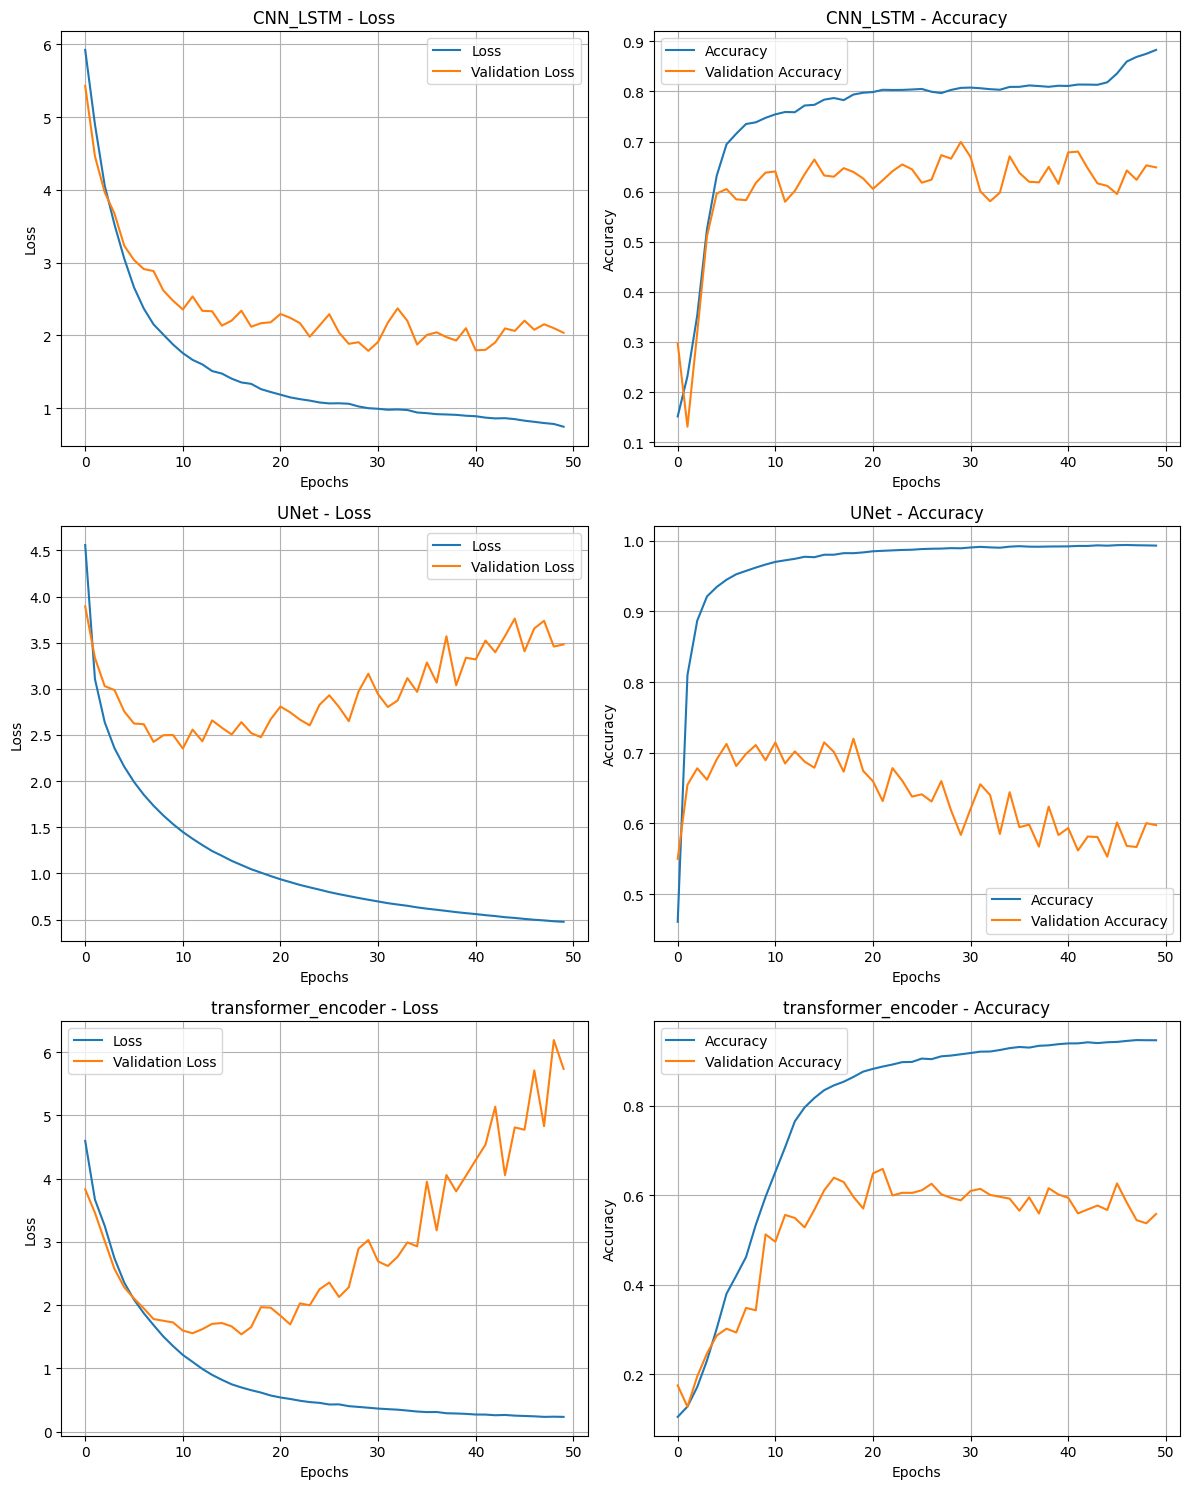

In [30]:
# loss, validation loss, acc, validation acc visualliztion

def draw_history(histories):
    num_models = len(histories)
    fig, ax = plt.subplots(num_models, 2, figsize=(12, 5 * num_models))

    for i, (model_name, history) in enumerate(histories.items()):
        ax[i, 0].plot(history.history['loss'], label='Loss')
        ax[i, 0].plot(history.history['val_loss'], label='Validation Loss')
        ax[i, 0].set_title(f'{model_name} - Loss')
        ax[i, 0].set_xlabel('Epochs')
        ax[i, 0].set_ylabel('Loss')
        ax[i, 0].legend()
        ax[i, 0].grid()

        ax[i, 1].plot(history.history['accuracy'], label='Accuracy')
        ax[i, 1].plot(history.history['val_accuracy'], label='Validation Accuracy')
        ax[i, 1].set_title(f'{model_name} - Accuracy')
        ax[i, 1].set_xlabel('Epochs')
        ax[i, 1].set_ylabel('Accuracy')
        ax[i, 1].legend()
        ax[i, 1].grid()

    plt.tight_layout()
    plt.show()

draw_history(histories_original)

In [31]:
# evaulate

def extract_train_test_scores(models, X_train, y_train, X_test, y_test) :
    scores = {}
    for model_name, model in models.items():
        if model:
            train_score = model.evaluate(X_train, y_train, verbose=0)
            test_score  = model.evaluate(X_test, y_test, verbose=0)
            scores[model_name] = {'train_score': train_score, 'test_score': test_score}
    return scores


evaluation_original = extract_train_test_scores(trained_models, X_train_seq, y_train_seq,
                                                X_test_seq, y_test_seq)
print (evaluation_original)

{'CNN_LSTM': {'train_score': [0.9349952936172485, 0.8502123355865479], 'test_score': [3.4768025875091553, 0.4519151449203491]}, 'UNet': {'train_score': [1.0696717500686646, 0.9158280491828918], 'test_score': [4.329364776611328, 0.4729715883731842]}, 'transformer_encoder': {'train_score': [2.1729469299316406, 0.7970917224884033], 'test_score': [3.8954954147338867, 0.49655064940452576]}}


In [32]:
# get accuracy, precision, recall, F1 score

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def extract_performance_metrics(models, X_test, y_test) :
    metrics = {}
    for model_name, model in models.items():
        if model:
            y_pred = model.predict(X_test)
            y_pred_classes = y_pred.argmax(axis=1)
            accuracy  = accuracy_score(y_test, y_pred_classes)
            precision = precision_score(y_test, y_pred_classes, average='weighted')
            recall    = recall_score(y_test, y_pred_classes, average='weighted')
            f1        = f1_score(y_test, y_pred_classes, average='weighted')
            metrics[model_name] = {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1_score': f1}
    return metrics

performances_original = extract_performance_metrics(trained_models, X_test_seq, y_test_seq)
print (performances_original)

607/607 [==============================] - 2s 3ms/step
{'CNN_LSTM': {'accuracy': 0.4519151565074135, 'precision': 0.40075046515082874, 'recall': 0.4519151565074135, 'f1_score': 0.4051910466862555}, 'UNet': {'accuracy': 0.4729715815485997, 'precision': 0.475147128019741, 'recall': 0.4729715815485997, 'f1_score': 0.4525228114229499}, 'transformer_encoder': {'accuracy': 0.4965506589785832, 'precision': 0.515963072535433, 'recall': 0.4965506589785832, 'f1_score': 0.4790814939214695}}


607/607 [==============================] - 3s 5ms/step
Classification Report for CNN_LSTM:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1208
           1       0.05      0.02      0.03      1147
           2       0.06      0.08      0.07      1258
           3       0.69      0.78      0.73      3262
           4       0.21      0.91      0.34      1011
           5       0.89      0.91      0.90      2408
           6       0.62      0.39      0.48      2881
           7       0.42      0.70      0.53      1466
           8       0.00      0.00      0.00      1064
           9       0.43      0.64      0.52      1313
          10       0.05      0.01      0.02      1649
          11       0.00      0.00      0.00       757

    accuracy                           0.45     19424
   macro avg       0.29      0.37      0.30     19424
weighted avg       0.40      0.45      0.41     19424



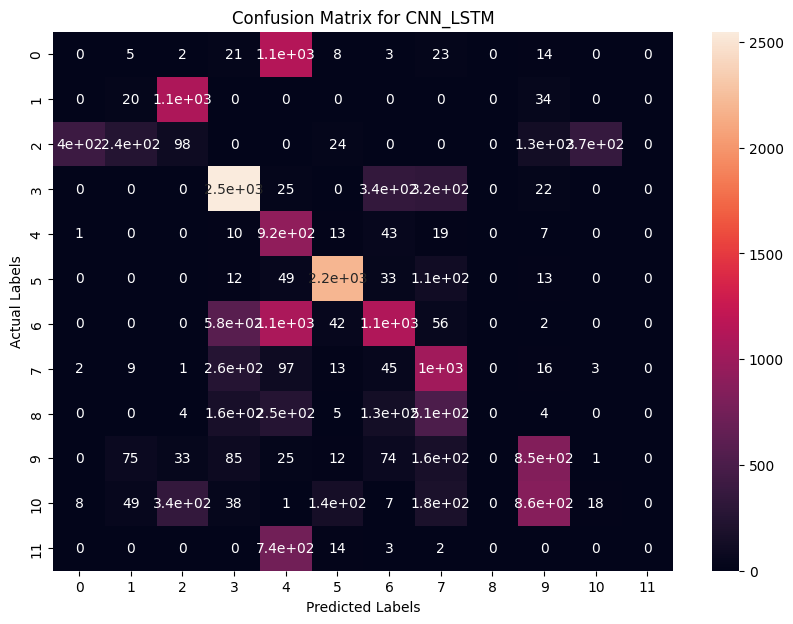

607/607 [==============================] - 1s 2ms/step
Classification Report for UNet:
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      1208
           1       0.88      0.83      0.86      1147
           2       0.56      0.49      0.52      1258
           3       0.52      0.60      0.56      3262
           4       0.37      0.60      0.46      1011
           5       0.69      0.38      0.49      2408
           6       0.29      0.19      0.23      2881
           7       0.42      0.22      0.29      1466
           8       0.29      0.82      0.43      1064
           9       0.30      0.55      0.38      1313
          10       0.01      0.00      0.00      1649
          11       0.70      0.70      0.70       757

    accuracy                           0.47     19424
   macro avg       0.49      0.53      0.49     19424
weighted avg       0.48      0.47      0.45     19424



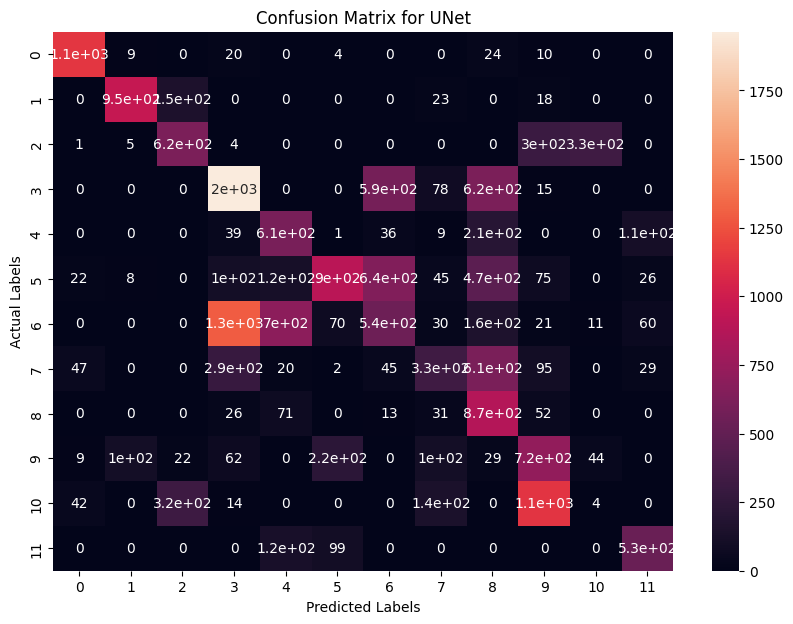

607/607 [==============================] - 2s 3ms/step
Classification Report for transformer_encoder:
              precision    recall  f1-score   support

           0       0.99      0.94      0.97      1208
           1       0.47      0.96      0.63      1147
           2       0.14      0.10      0.12      1258
           3       0.69      0.46      0.55      3262
           4       0.48      0.15      0.22      1011
           5       0.73      0.76      0.75      2408
           6       0.59      0.37      0.46      2881
           7       0.38      0.23      0.29      1466
           8       0.23      0.43      0.30      1064
           9       0.00      0.00      0.00      1313
          10       0.49      0.87      0.62      1649
          11       0.37      0.67      0.48       757

    accuracy                           0.50     19424
   macro avg       0.46      0.49      0.45     19424
weighted avg       0.52      0.50      0.48     19424



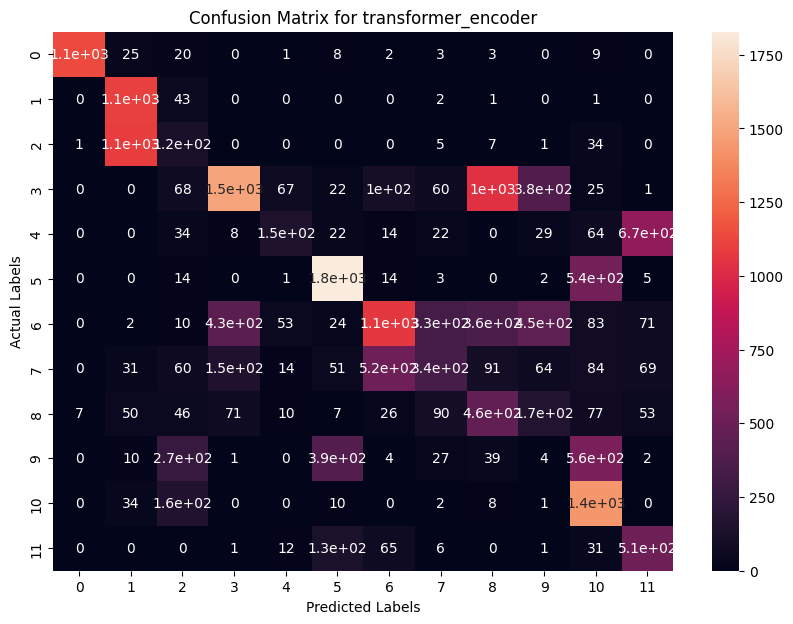

In [33]:
# draw confusion matrix, print the report

from sklearn.metrics import classification_report, confusion_matrix

def plot_classification_report_confusion_matrix(models, X_test, y_test):
    for model_name, model in models.items():
        if model:
            y_pred = model.predict(X_test)
            y_pred_classes = y_pred.argmax(axis=1) 
            
            # Print classification report
            print(f"Classification Report for {model_name}:")
            print(classification_report(y_test, y_pred_classes))
            
            # Generate and plot confusion matrix
            cm = confusion_matrix(y_test, y_pred_classes)
            plt.figure(figsize=(10, 7))
            sns.heatmap(cm, annot=True)
            plt.title(f'Confusion Matrix for {model_name}')
            plt.ylabel('Actual Labels')
            plt.xlabel('Predicted Labels')
            plt.show()

            
plot_classification_report_confusion_matrix(trained_models, X_test_seq, y_test_seq)

-----

### concat the original dataframe and augmented dataframe vs cross-structuring, implementation the augmentation

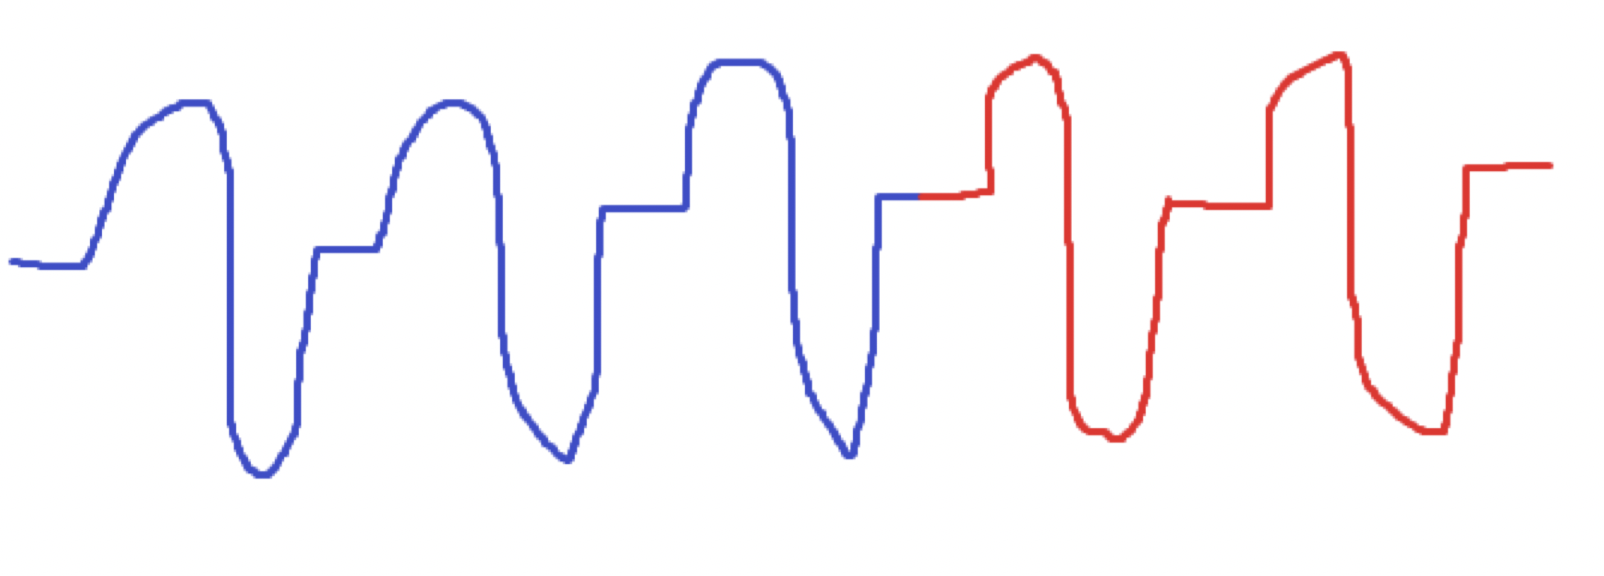

Several questions arose regarding the augmentation methods for time-series data. Initially, I took a simple approach by vertically concatenating the original DataFrame with the augmented DataFrame. However, I had concerns that this method would not adequately reflect the **time dependency** inherent in the data. Specifically, I thought that appending augmented data that restarts at 100Hz after the original sensor data, also measured at 100Hz, could lead the model to interpret the data as **discontinuous**.

To address this issue, I considered a strategy where augmentation is applied on a per-record basis, resulting in an alternating sequence of **original** and **augmented records**. This method is expected to better preserve the existing **patterns** and **continuity** of the data. Nonetheless, I recognized the importance of performing augmentation based on specific **activities**. For instance, in the case of regular activities like walking, it is necessary to account for the **periodic nature** of the data. I believed that shuffling the data before and after such activities may not significantly impact the analysis, as the data exhibits a consistent cyclical pattern.

Ultimately, I understood that the generated data is created by applying a linear transformation (wx+b) to the original data, allowing for the introduction of new data points while maintaining the overall **data flow**. This approach considers the unique characteristics of time-series data, providing a robust method for augmentation that can be effectively utilized in data analysis and model training.

In [34]:
from transforms3d.axangles import axangle2mat

def da_jitter(X, y, sigma=0.1):
    noise = np.random.normal(loc=0, scale=sigma, size=X.shape)
    return X + noise, y

def da_scaling(X, y, sigma=0.1):
    scaling_factor = np.random.normal(loc=1.0, scale=sigma, size=(1, X.shape[1]))
    return X * scaling_factor, y

def generate_random_curves(X, sigma=0.1, knot=4):
        xx = np.arange(0, X.shape[0], (X.shape[0]-1)/(knot+1))
        yy = np.random.normal(loc=1.0, scale=sigma, size=(knot+2, X.shape[1]))
        x_range = np.arange(X.shape[0])
        cs = [CubicSpline(xx, yy[:, i]) for i in range(X.shape[1])]
        return np.column_stack([cs[i](x_range) for i in range(X.shape[1])])
    
def da_mag_warp(X, y, sigma=0.1, knot=4):
    return X * generate_random_curves(X, sigma, knot), y

def da_time_warp(X, y, sigma=0.1):
    def distort_timesteps(X, sigma=0.1):
        tt = generate_random_curves(X, sigma)  # Reuse function from da_mag_warp
        tt_cum = np.cumsum(tt, axis=0)
        t_scale = (X.shape[0] - 1) / tt_cum[-1]
        return tt_cum * t_scale
    
    # Ensure X is a NumPy array
    X = X.to_numpy() if isinstance(X, pd.DataFrame) else X

    tt_new = distort_timesteps(X, sigma)
    X_new = np.zeros_like(X)
    x_range = np.arange(X.shape[0])
    
    for i in range(X.shape[1]):
        X_new[:, i] = np.interp(x_range, tt_new[:, i], X[:, i])
    
    return X_new, y

def da_rotation(X, y, theta):
    X_rotated = X.copy().to_numpy() 
    cos_theta, sin_theta = np.cos(theta), np.sin(theta)

    for i in range(0, X_rotated.shape[1] - 1, 2):
        x_i = X_rotated[:, i]
        x_j = X_rotated[:, i + 1]
        X_rotated[:, i] = cos_theta * x_i - sin_theta * x_j
        X_rotated[:, i + 1] = sin_theta * x_i + cos_theta * x_j

    return X_rotated, y

# def da_permutation(X, y, nPerm=4, minSegLength=10):
#     X_new = np.zeros_like(X)
    
#     # Generate random permutation of nPerm indices
#     idx = np.random.permutation(nPerm)
    
#     # Initialize segment indices
#     segs = np.zeros(nPerm + 1, dtype=int)
    
#     # Ensure segments are within valid range and sorted
#     segs[1:-1] = np.sort(np.random.randint(minSegLength, X.shape[0] - minSegLength, nPerm - 1))
#     segs[-1] = X.shape[0]  # Last segment ends at the end of X
    
#     pp = 0  # Pointer to fill the new array
#     for i in range(nPerm):
#         # Select a segment according to permuted indices
#         temp = X[segs[idx[i]]:segs[idx[i] + 1], :]
#         # Place the selected segment in the new array
#         X_new[pp:pp + temp.shape[0], :] = temp
#         pp += temp.shape[0]  # Update pointer
    
#     return X_new, y

def da_rand_sampling(X, y, nSample=50):
    X = np.array(X)
    y = np.array(y)
    tt = np.sort(np.random.choice(X.shape[0], size=nSample, replace=True))
    X_new = np.zeros_like(X)
    for i in range(X.shape[1]):
        X_new[:, i] = np.interp(np.arange(X.shape[0]), tt, X[tt, i])
    return X_new, y

def augment_and_split_by_activity(X, y, params, aug_way, n_steps, hop=1):
    activities = np.unique(y)
    X_augmented_list = []
    y_augmented_list = []

    for activity in activities:
        activity_mask = (y == activity)
        X_activity = X[activity_mask]
        y_activity = y[activity_mask]

        if aug_way == "jitter":
            X_augmented, y_augmented = da_jitter(X_activity, y_activity, sigma=params[0])
        elif aug_way == "scaling":
            X_augmented, y_augmented = da_scaling(X_activity, y_activity, sigma=params[0])
        elif aug_way == "magnitude_warp":
            X_augmented, y_augmented = da_mag_warp(X_activity, y_activity, sigma=params[0], knot=params[1])
        elif aug_way == "time_warp":
            X_augmented, y_augmented = da_time_warp(X_activity, y_activity, sigma=params[0])
        elif aug_way == "rotation":
            X_augmented, y_augmented = da_rotation(X_activity, y_activity, theta=params[0])
        elif aug_way == "permutation":
            X_augmented, y_augmented = da_permutation(X_activity, y_activity, nPerm=params[0], minSegLength=params[1])
        elif aug_way == "rand_sampling":
            X_augmented, y_augmented = da_rand_sampling(X_activity, y_activity, nSample=params[0])
        else:
            raise ValueError(f"Unknown augmentation method: {aug_way}")

        # Combine X_augmented and y_augmented into a single DataFrame
        augmented_data = np.column_stack((X_augmented, y_augmented))
        
        # Split the augmented data into sequences
        X_seq, y_seq = split_sequences_freq(augmented_data, n_steps, hop)
        
        X_augmented_list.append(X_seq)
        y_augmented_list.append(y_seq)

    X_augmented = np.vstack(X_augmented_list)
    y_augmented = np.concatenate(y_augmented_list)

    return X_augmented, y_augmented


------

### Jitter

In [35]:
X_augmented, y_augmented = augment_and_split_by_activity(X_train, y_train, 
                                                         params=[0.1], aug_way='jitter', n_steps=100, hop=10)

X = np.vstack((X_train_seq, X_augmented))
y = np.concatenate((y_train_seq, y_augmented))

print (X.shape, y.shape)

(233027, 100, 35) (233027,)


In [36]:
# fit

histories_jitter, trained_models = activate_all_model(X, y, input_shape, n_classes)

CNN_LSTM model parameters: 107228
UNet model parameters: 164572
Transformer Encoder model parameters: 114934
ERROR: Could not find file /tmp/ipykernel_37619/2750405356.py
model 0 running
epoch 1 completed : 27.20 seconds
epoch 2 completed : 8.88 seconds
epoch 3 completed : 8.67 seconds
epoch 4 completed : 8.73 seconds
epoch 5 completed : 8.71 seconds
epoch 6 completed : 8.81 seconds
epoch 7 completed : 8.80 seconds
epoch 8 completed : 8.80 seconds
epoch 9 completed : 8.90 seconds
epoch 10 completed : 8.52 seconds
epoch 11 completed : 8.88 seconds
epoch 12 completed : 8.84 seconds
epoch 13 completed : 8.59 seconds
epoch 14 completed : 8.76 seconds
epoch 15 completed : 8.79 seconds
epoch 16 completed : 8.55 seconds
epoch 17 completed : 8.92 seconds
epoch 18 completed : 8.67 seconds
epoch 19 completed : 9.01 seconds
epoch 20 completed : 8.98 seconds
epoch 21 completed : 8.96 seconds
epoch 22 completed : 8.67 seconds
epoch 23 completed : 8.71 seconds
epoch 24 completed : 8.73 seconds
epoch

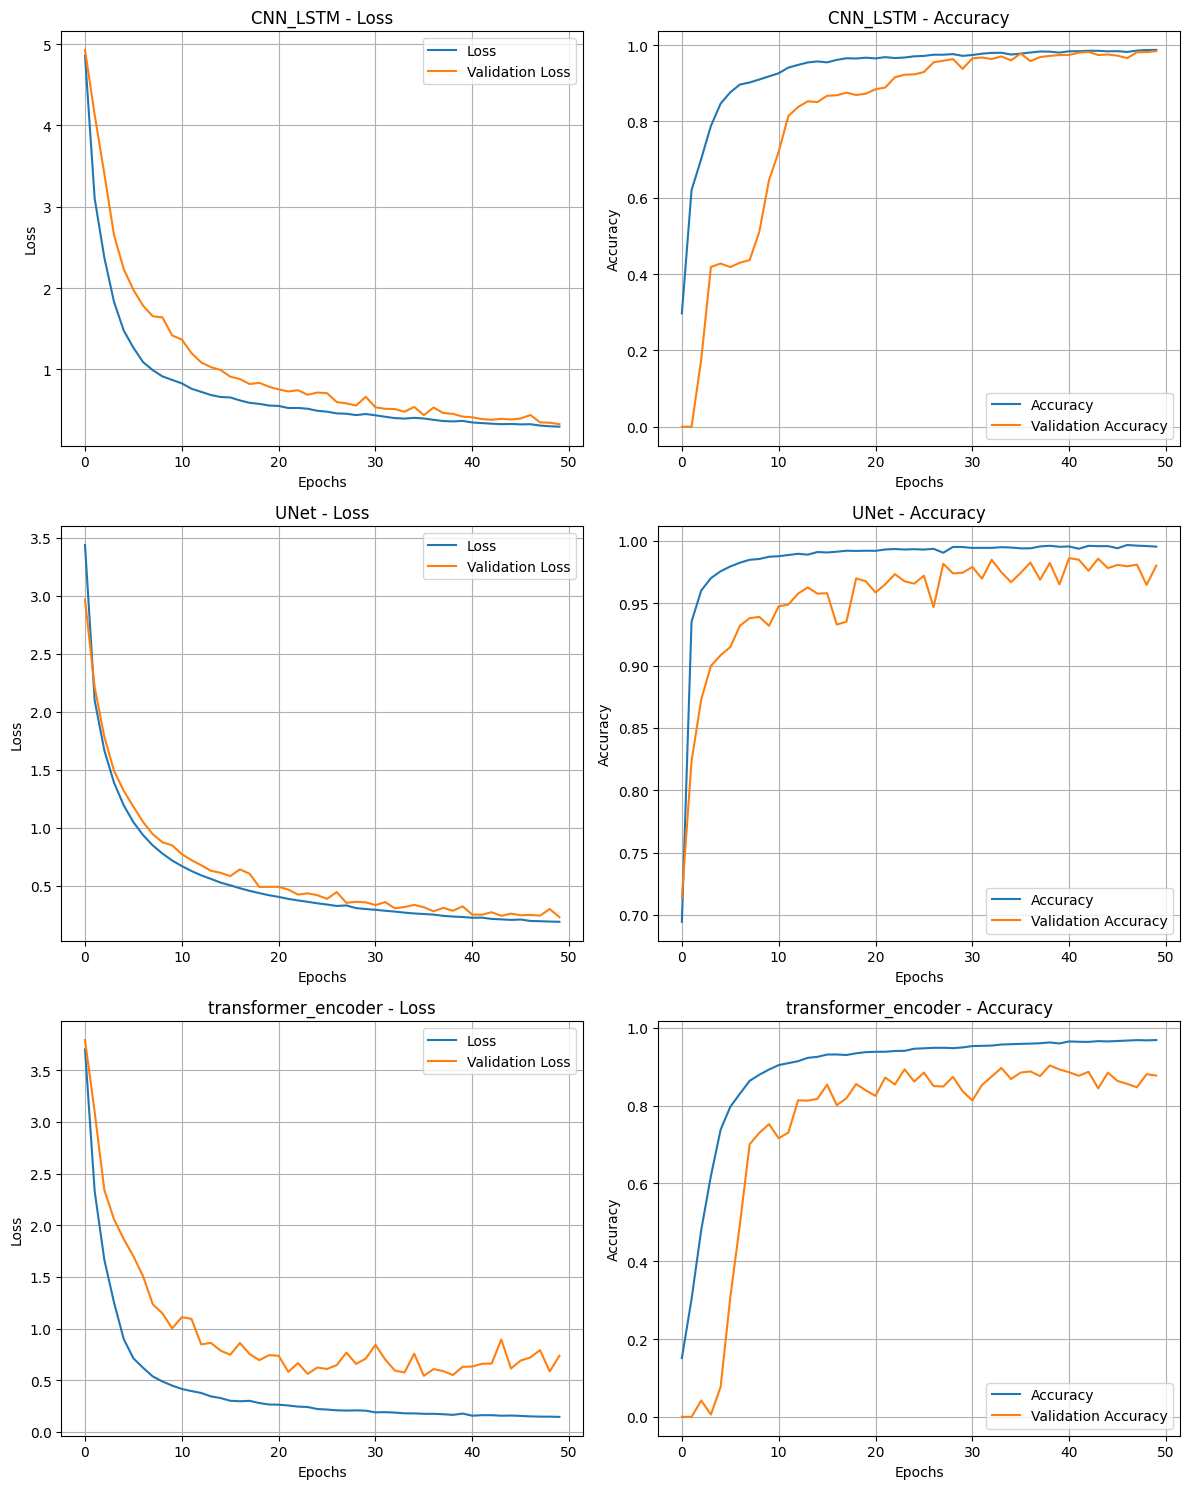

In [37]:
# draw loss, val_loss, acc, val_acc

draw_history(histories_jitter)

In [38]:
# evaluate

evaluation_jitter = extract_train_test_scores(trained_models, X, y,
                                                 X_test_seq, y_test_seq)
print (evaluation_jitter)

{'CNN_LSTM': {'train_score': [0.2599330544471741, 0.9942324161529541], 'test_score': [4.663599014282227, 0.41428130865097046]}, 'UNet': {'train_score': [0.1976495087146759, 0.9921683073043823], 'test_score': [3.9143505096435547, 0.42313632369041443]}, 'transformer_encoder': {'train_score': [0.7155179381370544, 0.8517768383026123], 'test_score': [6.491177558898926, 0.5198723077774048]}}


In [39]:
# get accuracy, precision, recall, F1 score

performances_jitter = extract_performance_metrics(trained_models, X_test_seq, y_test_seq)
print (performances_jitter)

607/607 [==============================] - 2s 3ms/step
{'CNN_LSTM': {'accuracy': 0.4142813014827018, 'precision': 0.4428964236201029, 'recall': 0.4142813014827018, 'f1_score': 0.3837049240601368}, 'UNet': {'accuracy': 0.42313632619439867, 'precision': 0.4337463053696483, 'recall': 0.42313632619439867, 'f1_score': 0.4137173650146136}, 'transformer_encoder': {'accuracy': 0.5198723228995058, 'precision': 0.5625204279459559, 'recall': 0.5198723228995058, 'f1_score': 0.5246748594919798}}


607/607 [==============================] - 3s 5ms/step
Classification Report for CNN_LSTM:
              precision    recall  f1-score   support

           0       0.03      0.02      0.02      1208
           1       0.45      0.97      0.61      1147
           2       0.90      0.45      0.60      1258
           3       0.52      0.57      0.54      3262
           4       0.52      0.65      0.58      1011
           5       0.72      0.23      0.35      2408
           6       0.45      0.18      0.26      2881
           7       0.32      0.54      0.40      1466
           8       0.22      0.49      0.30      1064
           9       0.34      0.70      0.45      1313
          10       0.02      0.00      0.00      1649
          11       0.65      0.70      0.67       757

    accuracy                           0.41     19424
   macro avg       0.43      0.46      0.40     19424
weighted avg       0.44      0.41      0.38     19424



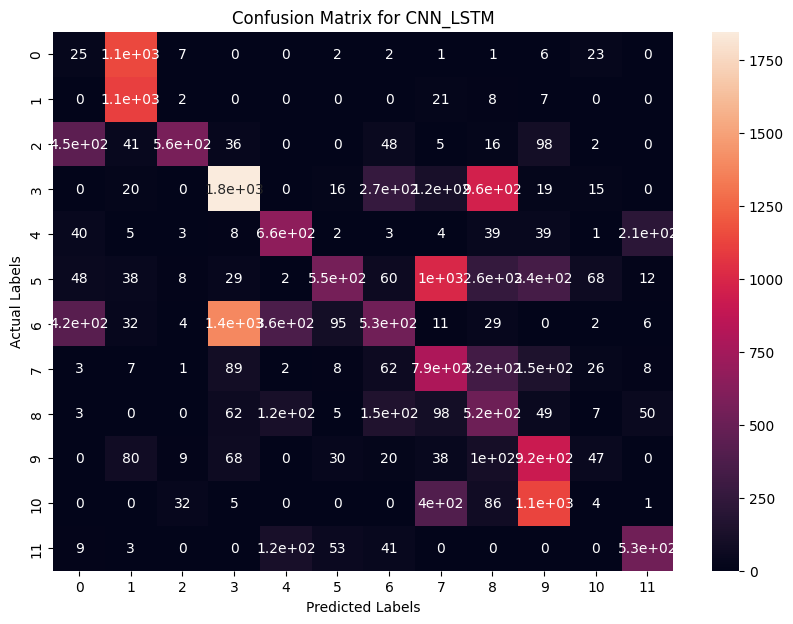

607/607 [==============================] - 1s 2ms/step
Classification Report for UNet:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1208
           1       0.49      0.27      0.35      1147
           2       0.17      0.19      0.18      1258
           3       0.53      0.58      0.56      3262
           4       0.66      0.66      0.66      1011
           5       0.91      0.81      0.86      2408
           6       0.42      0.24      0.30      2881
           7       0.62      0.46      0.53      1466
           8       0.12      0.42      0.18      1064
           9       0.32      0.58      0.41      1313
          10       0.00      0.00      0.00      1649
          11       0.55      0.73      0.62       757

    accuracy                           0.42     19424
   macro avg       0.40      0.41      0.39     19424
weighted avg       0.43      0.42      0.41     19424



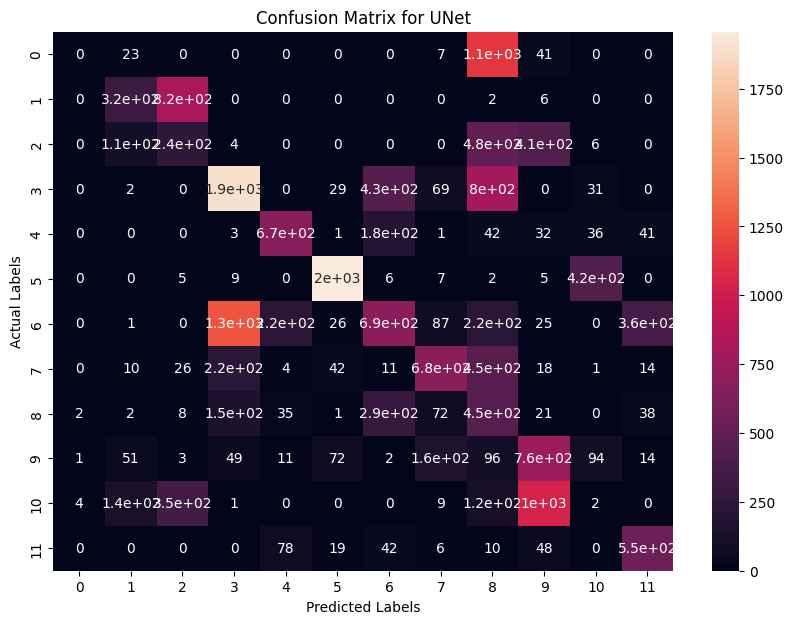

607/607 [==============================] - 2s 3ms/step
Classification Report for transformer_encoder:
              precision    recall  f1-score   support

           0       0.78      0.95      0.85      1208
           1       0.01      0.00      0.00      1147
           2       0.36      0.55      0.44      1258
           3       0.69      0.48      0.57      3262
           4       0.45      0.36      0.40      1011
           5       0.88      0.57      0.69      2408
           6       0.61      0.46      0.53      2881
           7       0.36      0.62      0.46      1466
           8       0.17      0.38      0.24      1064
           9       0.56      0.65      0.60      1313
          10       0.75      0.66      0.70      1649
          11       0.35      0.46      0.40       757

    accuracy                           0.52     19424
   macro avg       0.50      0.51      0.49     19424
weighted avg       0.56      0.52      0.52     19424



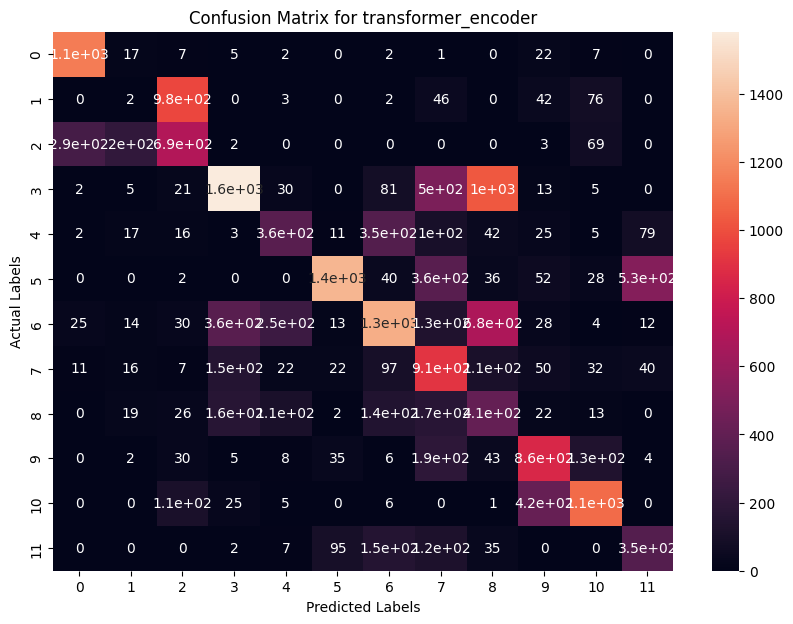

In [40]:
# draw confusion matrix, print the report

plot_classification_report_confusion_matrix(trained_models, X_test_seq, y_test_seq)


----


### scaling

In [41]:
X_augmented, y_augmented = augment_and_split_by_activity(X_train, y_train, 
                                                         params=[0.1], aug_way='scaling', n_steps=100, hop=10)

X = np.vstack((X_train_seq, X_augmented))
y = np.concatenate((y_train_seq, y_augmented))

print (X.shape, y.shape)

(233027, 100, 35) (233027,)


In [42]:
# fit

histories_scaling, trained_models = activate_all_model(X, y, input_shape, n_classes)

CNN_LSTM model parameters: 107228
UNet model parameters: 164572
Transformer Encoder model parameters: 114934
ERROR: Could not find file /tmp/ipykernel_37619/2750405356.py
model 0 running
epoch 1 completed : 26.93 seconds
epoch 2 completed : 8.67 seconds
epoch 3 completed : 8.65 seconds
epoch 4 completed : 8.69 seconds
epoch 5 completed : 8.77 seconds
epoch 6 completed : 8.83 seconds
epoch 7 completed : 8.63 seconds
epoch 8 completed : 8.46 seconds
epoch 9 completed : 8.80 seconds
epoch 10 completed : 8.89 seconds
epoch 11 completed : 8.61 seconds
epoch 12 completed : 8.65 seconds
epoch 13 completed : 8.67 seconds
epoch 14 completed : 8.58 seconds
epoch 15 completed : 8.74 seconds
epoch 16 completed : 8.64 seconds
epoch 17 completed : 8.82 seconds
epoch 18 completed : 9.23 seconds
epoch 19 completed : 8.63 seconds
epoch 20 completed : 8.69 seconds
epoch 21 completed : 8.71 seconds
epoch 22 completed : 8.59 seconds
epoch 23 completed : 8.63 seconds
epoch 24 completed : 8.57 seconds
epoch

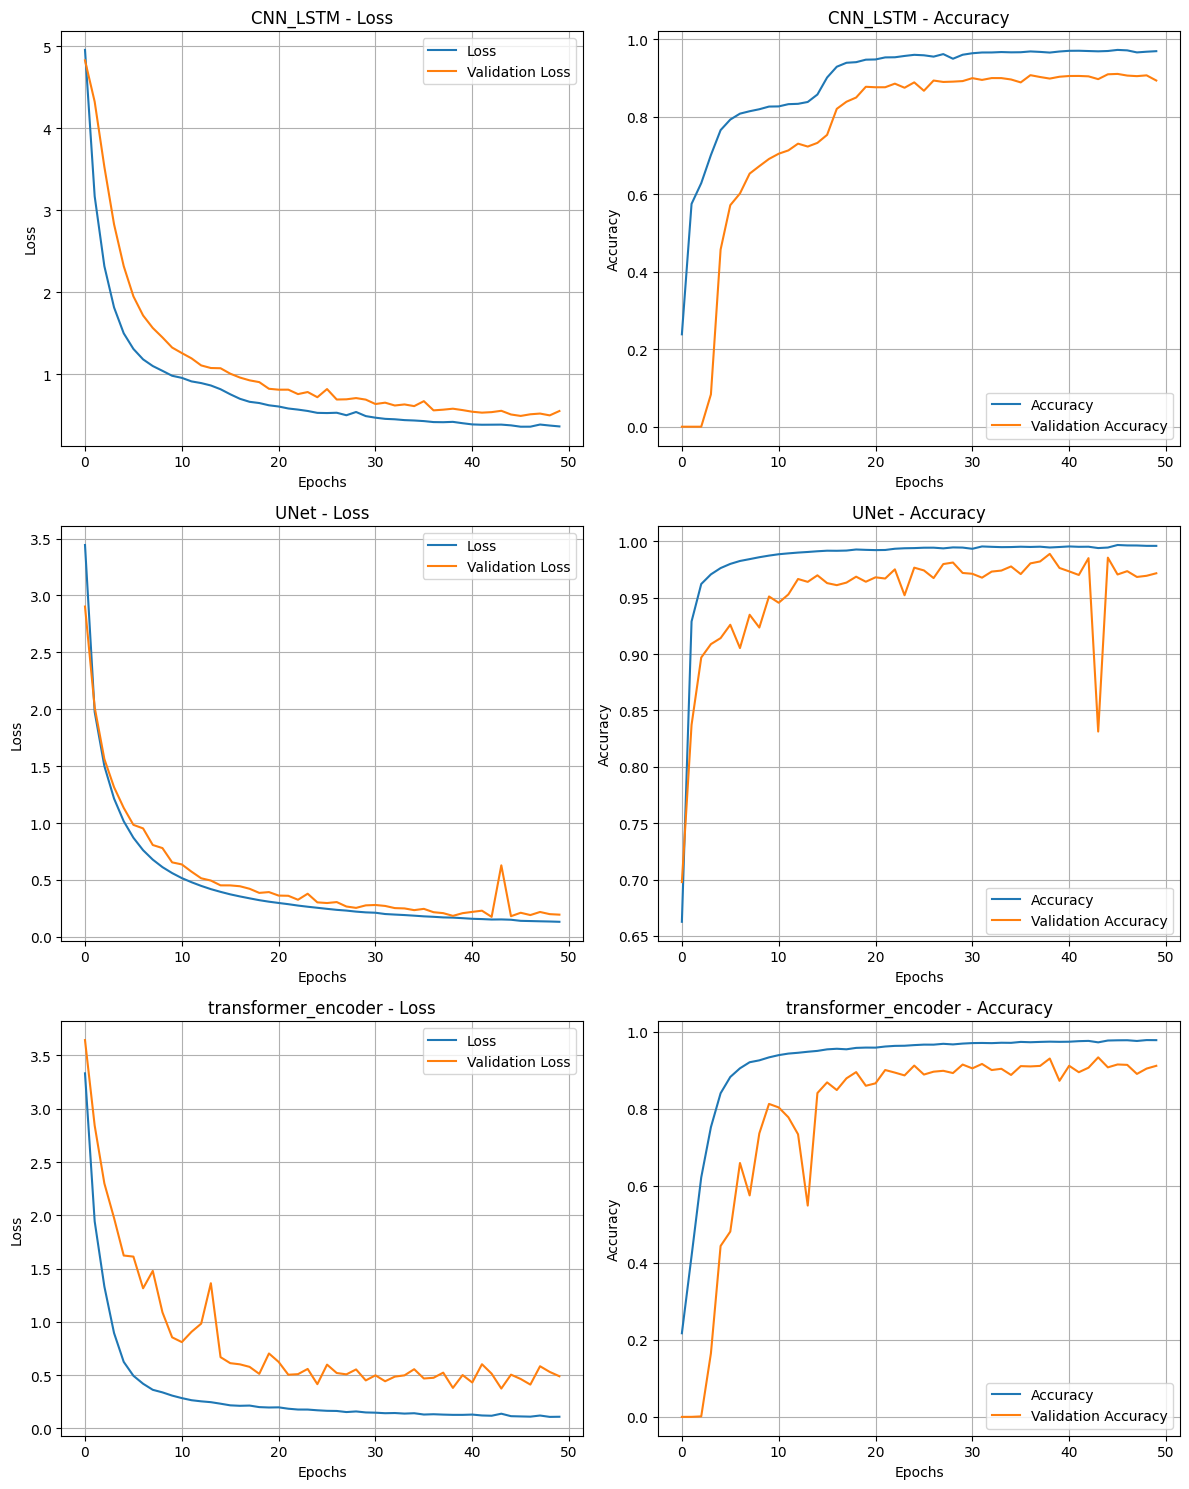

In [43]:
# draw loss, val_loss, acc, val_acc

draw_history(histories_scaling)

In [44]:
# evaluate

evaluation_scaling = extract_train_test_scores(trained_models, X, y,
                                                 X_test_seq, y_test_seq)
print (evaluation_scaling)

{'CNN_LSTM': {'train_score': [0.35558757185935974, 0.9650512337684631], 'test_score': [3.685511589050293, 0.44949546456336975]}, 'UNet': {'train_score': [0.14481206238269806, 0.990323007106781], 'test_score': [3.972938299179077, 0.4574752748012543]}, 'transformer_encoder': {'train_score': [0.40003636479377747, 0.9432511925697327], 'test_score': [4.121269702911377, 0.5248661637306213]}}


In [45]:
# get accuracy, precision, recall, F1 score

performances_scaling = extract_performance_metrics(trained_models, X_test_seq, y_test_seq)
print (performances_scaling)

607/607 [==============================] - 2s 3ms/step
{'CNN_LSTM': {'accuracy': 0.4494954695222405, 'precision': 0.46339255760562337, 'recall': 0.4494954695222405, 'f1_score': 0.4216742076543049}, 'UNet': {'accuracy': 0.45747528830313017, 'precision': 0.5087979387688911, 'recall': 0.45747528830313017, 'f1_score': 0.43346190392164285}, 'transformer_encoder': {'accuracy': 0.5248661449752883, 'precision': 0.5651548811678296, 'recall': 0.5248661449752883, 'f1_score': 0.5096689758627602}}


607/607 [==============================] - 3s 5ms/step
Classification Report for CNN_LSTM:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1208
           1       0.46      0.99      0.62      1147
           2       0.70      0.44      0.54      1258
           3       0.65      0.51      0.57      3262
           4       0.38      0.86      0.53      1011
           5       0.95      0.44      0.60      2408
           6       0.55      0.51      0.53      2881
           7       0.43      0.38      0.40      1466
           8       0.19      0.44      0.27      1064
           9       0.29      0.72      0.41      1313
          10       0.01      0.00      0.00      1649
          11       0.00      0.00      0.00       757

    accuracy                           0.45     19424
   macro avg       0.38      0.44      0.37     19424
weighted avg       0.46      0.45      0.42     19424



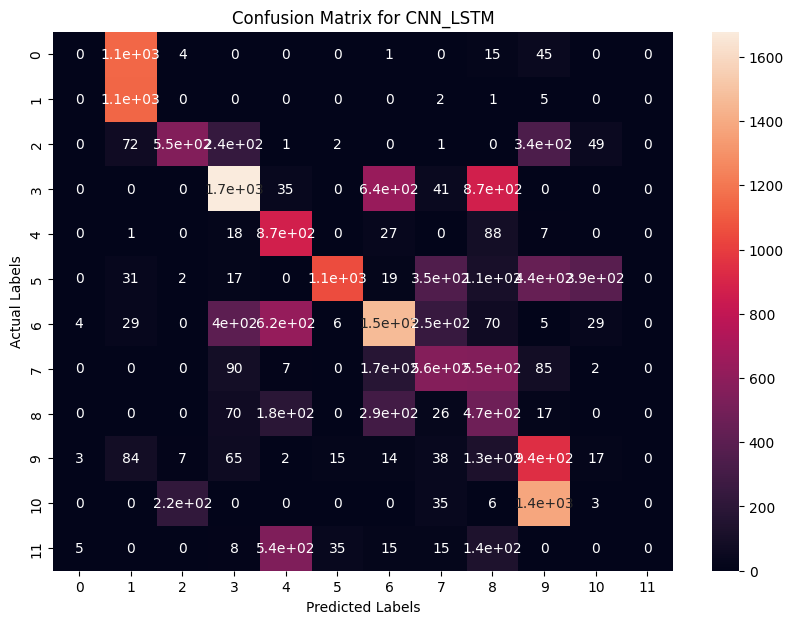

607/607 [==============================] - 2s 2ms/step
Classification Report for UNet:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1208
           1       0.42      0.95      0.58      1147
           2       0.76      0.90      0.82      1258
           3       0.59      0.50      0.54      3262
           4       0.37      0.72      0.49      1011
           5       0.84      0.51      0.64      2408
           6       0.86      0.25      0.39      2881
           7       0.55      0.46      0.50      1466
           8       0.23      0.67      0.35      1064
           9       0.21      0.51      0.30      1313
          10       0.00      0.00      0.00      1649
          11       0.41      0.40      0.41       757

    accuracy                           0.46     19424
   macro avg       0.44      0.49      0.42     19424
weighted avg       0.51      0.46      0.43     19424



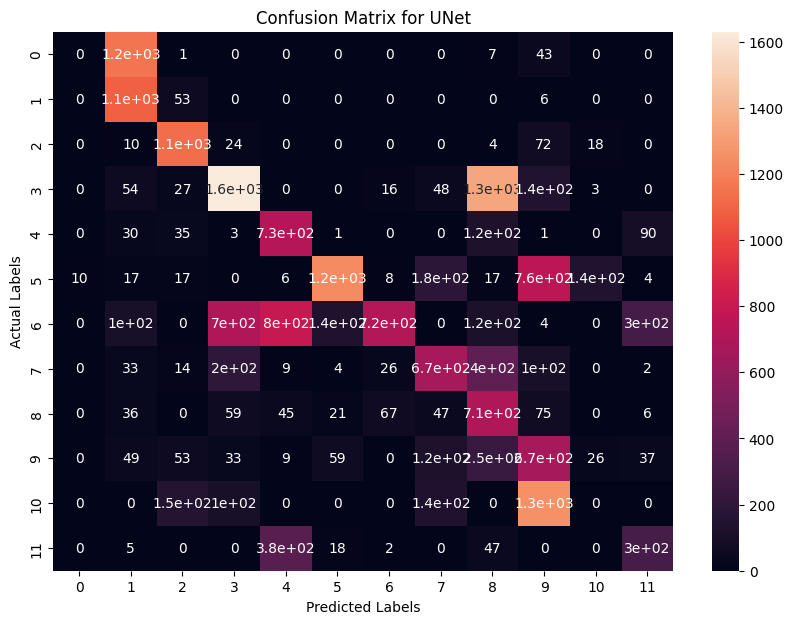

607/607 [==============================] - 2s 3ms/step
Classification Report for transformer_encoder:
              precision    recall  f1-score   support

           0       0.86      0.04      0.07      1208
           1       0.34      0.84      0.48      1147
           2       0.41      0.42      0.41      1258
           3       0.57      0.53      0.55      3262
           4       0.27      0.14      0.18      1011
           5       0.84      0.88      0.86      2408
           6       0.49      0.45      0.47      2881
           7       0.46      0.54      0.50      1466
           8       0.34      0.39      0.36      1064
           9       0.57      0.70      0.63      1313
          10       0.81      0.51      0.62      1649
          11       0.45      0.54      0.49       757

    accuracy                           0.52     19424
   macro avg       0.53      0.50      0.47     19424
weighted avg       0.57      0.52      0.51     19424



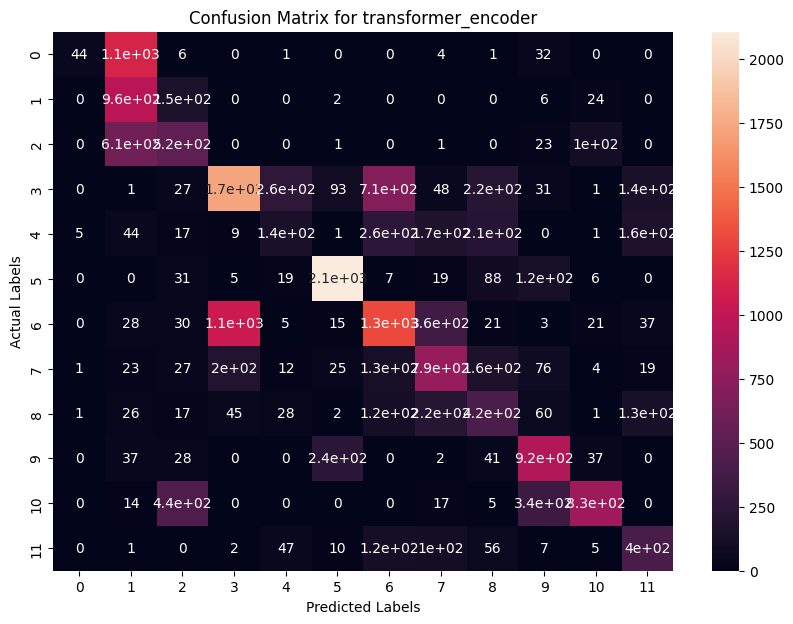

In [46]:
# draw confusion matrix, print the report

plot_classification_report_confusion_matrix(trained_models, X_test_seq, y_test_seq)

-----

### magnitude_warp

In [47]:
X_augmented, y_augmented = augment_and_split_by_activity(X_train, y_train, 
                                                         params=[0.1, 4], aug_way='magnitude_warp', 
                                                         n_steps=100, hop=10)
X = np.vstack((X_train_seq, X_augmented))
y = np.concatenate((y_train_seq, y_augmented))

print (X.shape, y.shape)

(233027, 100, 35) (233027,)


In [48]:
# fit

histories_magnitude_warp, trained_models = activate_all_model(X, y, input_shape, n_classes)

CNN_LSTM model parameters: 107228
UNet model parameters: 164572
Transformer Encoder model parameters: 114934
ERROR: Could not find file /tmp/ipykernel_37619/2750405356.py
model 0 running
epoch 1 completed : 27.99 seconds
epoch 2 completed : 8.91 seconds
epoch 3 completed : 8.77 seconds
epoch 4 completed : 8.72 seconds
epoch 5 completed : 8.65 seconds
epoch 6 completed : 8.76 seconds
epoch 7 completed : 8.68 seconds
epoch 8 completed : 8.59 seconds
epoch 9 completed : 8.74 seconds
epoch 10 completed : 8.62 seconds
epoch 11 completed : 8.66 seconds
epoch 12 completed : 8.82 seconds
epoch 13 completed : 8.86 seconds
epoch 14 completed : 8.75 seconds
epoch 15 completed : 8.77 seconds
epoch 16 completed : 8.65 seconds
epoch 17 completed : 8.80 seconds
epoch 18 completed : 8.76 seconds
epoch 19 completed : 8.65 seconds
epoch 20 completed : 8.94 seconds
epoch 21 completed : 8.91 seconds
epoch 22 completed : 8.83 seconds
epoch 23 completed : 8.75 seconds
epoch 24 completed : 9.07 seconds
epoch

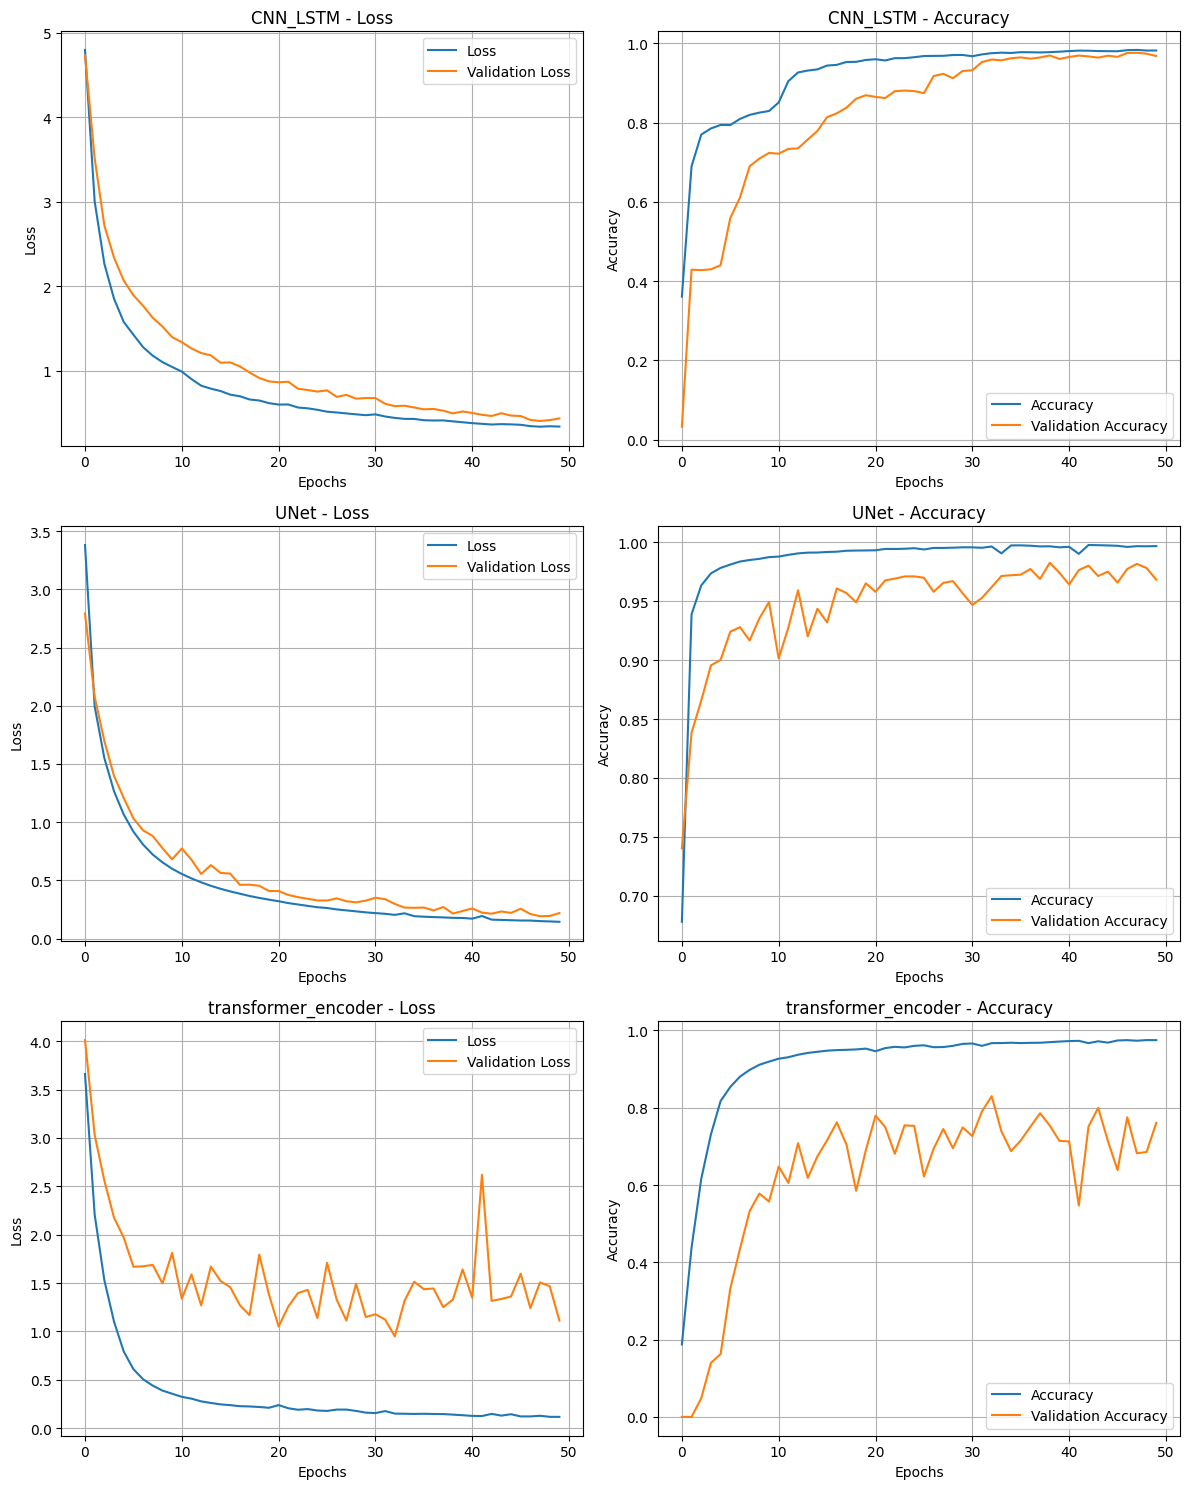

In [49]:
# draw loss, val_loss, acc, val_acc

draw_history(histories_magnitude_warp)

In [50]:
# evaluate

evaluation_magnitude_warp = extract_train_test_scores(trained_models, X, y,
                                                 X_test_seq, y_test_seq)
print (evaluation_magnitude_warp)

{'CNN_LSTM': {'train_score': [0.3124425709247589, 0.9878597855567932], 'test_score': [3.470970630645752, 0.5045819878578186]}, 'UNet': {'train_score': [0.1647644191980362, 0.9885077476501465], 'test_score': [3.7379322052001953, 0.45603376626968384]}, 'transformer_encoder': {'train_score': [1.1707946062088013, 0.7909812927246094], 'test_score': [5.539446830749512, 0.45896828174591064]}}


In [51]:
# get accuracy, precision, recall, F1 score

performances_magnitude_warp = extract_performance_metrics(trained_models, X_test_seq, y_test_seq)
print (performances_magnitude_warp)

607/607 [==============================] - 2s 3ms/step
{'CNN_LSTM': {'accuracy': 0.504581960461285, 'precision': 0.6399950790468142, 'recall': 0.504581960461285, 'f1_score': 0.4979993598424534}, 'UNet': {'accuracy': 0.4560337726523888, 'precision': 0.4757259359967324, 'recall': 0.4560337726523888, 'f1_score': 0.4169238075923265}, 'transformer_encoder': {'accuracy': 0.4589682866556837, 'precision': 0.48810764153944275, 'recall': 0.4589682866556837, 'f1_score': 0.44896952312725563}}


607/607 [==============================] - 3s 5ms/step
Classification Report for CNN_LSTM:
              precision    recall  f1-score   support

           0       0.95      0.94      0.95      1208
           1       0.87      0.95      0.91      1147
           2       0.86      0.60      0.71      1258
           3       0.53      0.46      0.49      3262
           4       0.45      0.77      0.57      1011
           5       0.76      0.29      0.42      2408
           6       0.96      0.30      0.46      2881
           7       0.59      0.44      0.51      1466
           8       0.25      0.72      0.37      1064
           9       0.24      0.78      0.36      1313
          10       0.38      0.02      0.04      1649
          11       0.45      0.66      0.53       757

    accuracy                           0.50     19424
   macro avg       0.61      0.58      0.53     19424
weighted avg       0.64      0.50      0.50     19424



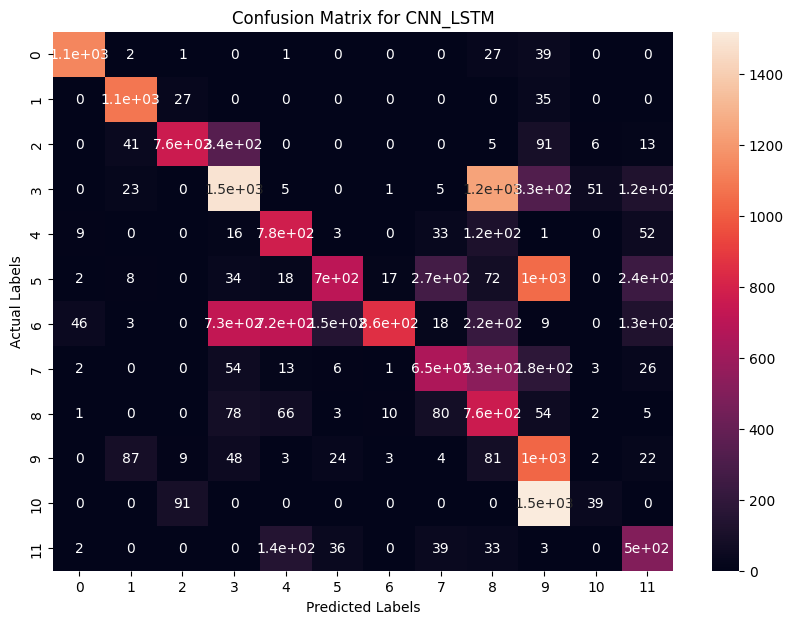

607/607 [==============================] - 1s 2ms/step
Classification Report for UNet:
              precision    recall  f1-score   support

           0       0.05      0.01      0.02      1208
           1       0.39      0.99      0.56      1147
           2       0.11      0.03      0.04      1258
           3       0.70      0.61      0.65      3262
           4       0.38      0.41      0.39      1011
           5       0.81      0.81      0.81      2408
           6       0.83      0.21      0.34      2881
           7       0.47      0.50      0.48      1466
           8       0.23      0.58      0.33      1064
           9       0.25      0.61      0.36      1313
          10       0.00      0.00      0.00      1649
          11       0.42      0.75      0.54       757

    accuracy                           0.46     19424
   macro avg       0.39      0.46      0.38     19424
weighted avg       0.48      0.46      0.42     19424



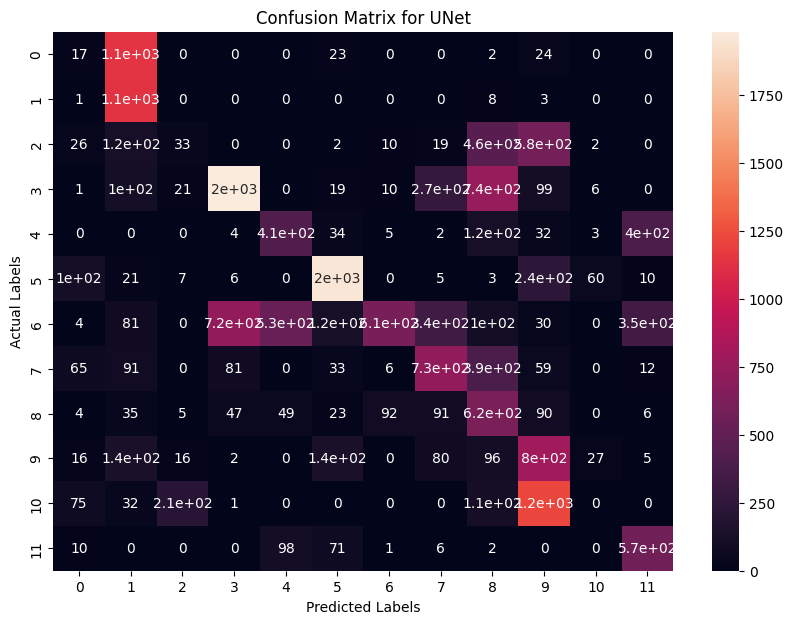

607/607 [==============================] - 2s 3ms/step
Classification Report for transformer_encoder:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1208
           1       0.84      0.90      0.87      1147
           2       0.37      0.90      0.52      1258
           3       0.48      0.52      0.50      3262
           4       0.27      0.51      0.35      1011
           5       0.90      0.48      0.62      2408
           6       0.46      0.28      0.35      2881
           7       0.29      0.38      0.33      1466
           8       0.24      0.35      0.28      1064
           9       0.47      0.40      0.43      1313
          10       0.65      0.43      0.52      1649
          11       0.42      0.57      0.48       757

    accuracy                           0.46     19424
   macro avg       0.45      0.48      0.44     19424
weighted avg       0.49      0.46      0.45     19424



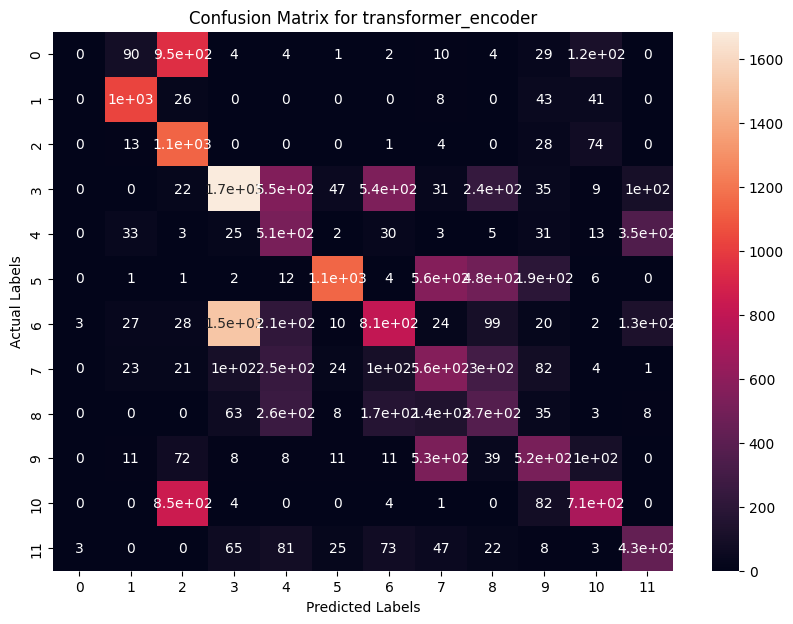

In [52]:
# draw confusion matrix, print the report

plot_classification_report_confusion_matrix(trained_models, X_test_seq, y_test_seq)

-----

### time_warp

In [53]:
X_augmented, y_augmented = augment_and_split_by_activity(X_train, y_train, 
                                                         params=[0.1, 4], aug_way='time_warp', 
                                                         n_steps=100, hop=10)


X = np.vstack((X_train_seq, X_augmented))
y = np.concatenate((y_train_seq, y_augmented))

print (X.shape, y.shape)

(233027, 100, 35) (233027,)


In [54]:
# fit

histories_time_warp, trained_models = activate_all_model(X, y, input_shape, n_classes)

CNN_LSTM model parameters: 107228
UNet model parameters: 164572
Transformer Encoder model parameters: 114934
ERROR: Could not find file /tmp/ipykernel_37619/2750405356.py
model 0 running
epoch 1 completed : 28.49 seconds
epoch 2 completed : 8.71 seconds
epoch 3 completed : 8.86 seconds
epoch 4 completed : 8.67 seconds
epoch 5 completed : 8.69 seconds
epoch 6 completed : 8.91 seconds
epoch 7 completed : 8.49 seconds
epoch 8 completed : 9.14 seconds
epoch 9 completed : 8.83 seconds
epoch 10 completed : 8.64 seconds
epoch 11 completed : 8.95 seconds
epoch 12 completed : 8.89 seconds
epoch 13 completed : 8.71 seconds
epoch 14 completed : 8.75 seconds
epoch 15 completed : 8.78 seconds
epoch 16 completed : 8.78 seconds
epoch 17 completed : 8.74 seconds
epoch 18 completed : 9.04 seconds
epoch 19 completed : 8.72 seconds
epoch 20 completed : 9.47 seconds
epoch 21 completed : 8.90 seconds
epoch 22 completed : 8.77 seconds
epoch 23 completed : 8.93 seconds
epoch 24 completed : 9.17 seconds
epoch

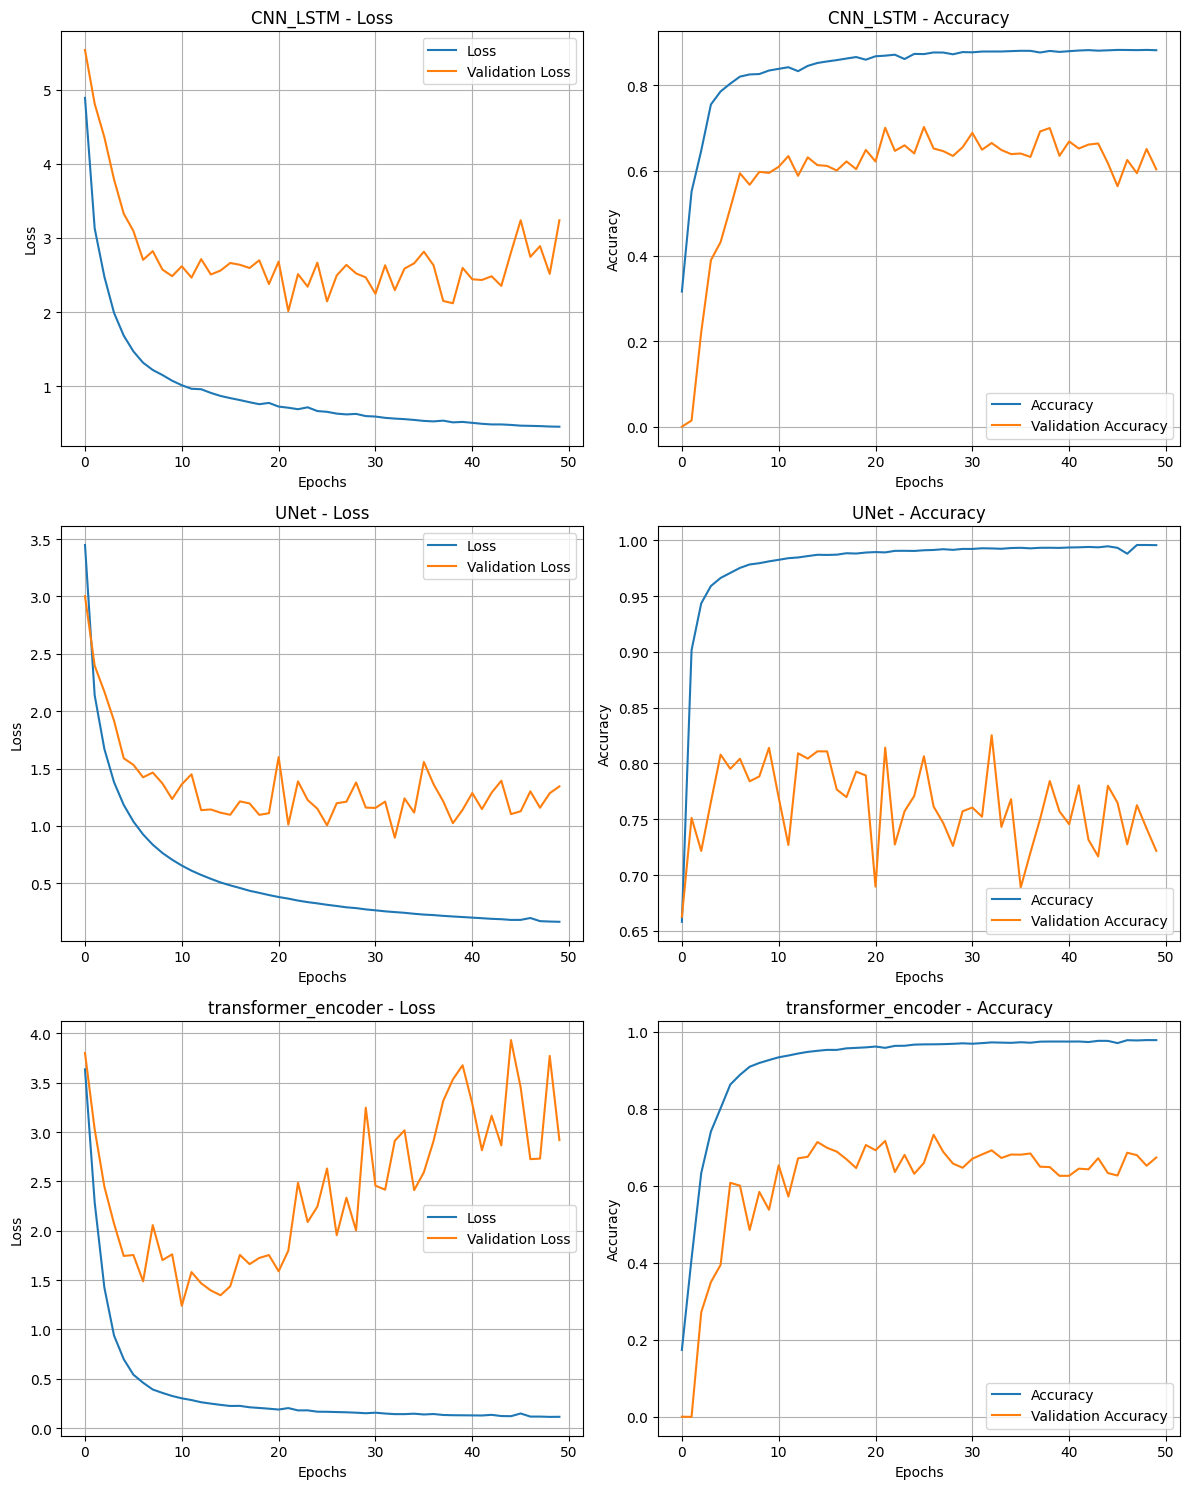

In [55]:
# draw loss, val_loss, acc, val_acc

draw_history(histories_time_warp)

In [56]:
# evaluate

evaluation_time_warp = extract_train_test_scores(trained_models, X, y,
                                                 X_test_seq, y_test_seq)
print (evaluation_time_warp)

{'CNN_LSTM': {'train_score': [0.994353175163269, 0.8298008441925049], 'test_score': [3.920236825942993, 0.4358525574207306]}, 'UNet': {'train_score': [0.4021576941013336, 0.9396207332611084], 'test_score': [4.1671037673950195, 0.45325371623039246]}, 'transformer_encoder': {'train_score': [0.9991547465324402, 0.8653889894485474], 'test_score': [7.064842700958252, 0.44398683309555054]}}


In [57]:
# get accuracy, precision, recall, F1 score

performances_time_warp = extract_performance_metrics(trained_models, X_test_seq, y_test_seq)
print (performances_time_warp)

607/607 [==============================] - 2s 3ms/step
{'CNN_LSTM': {'accuracy': 0.43585255354200986, 'precision': 0.4180054105754883, 'recall': 0.43585255354200986, 'f1_score': 0.4040456226246379}, 'UNet': {'accuracy': 0.45325370675453047, 'precision': 0.5919437327004047, 'recall': 0.45325370675453047, 'f1_score': 0.4254957595732882}, 'transformer_encoder': {'accuracy': 0.4439868204283361, 'precision': 0.4471396225846901, 'recall': 0.4439868204283361, 'f1_score': 0.41516293438035173}}


607/607 [==============================] - 3s 5ms/step
Classification Report for CNN_LSTM:
              precision    recall  f1-score   support

           0       0.97      0.94      0.95      1208
           1       0.82      0.94      0.87      1147
           2       0.62      0.70      0.66      1258
           3       0.35      0.33      0.34      3262
           4       0.50      0.91      0.65      1011
           5       0.80      0.44      0.57      2408
           6       0.00      0.00      0.00      2881
           7       0.42      0.58      0.49      1466
           8       0.15      0.65      0.24      1064
           9       0.28      0.42      0.34      1313
          10       0.01      0.00      0.00      1649
          11       0.63      0.30      0.41       757

    accuracy                           0.44     19424
   macro avg       0.46      0.52      0.46     19424
weighted avg       0.42      0.44      0.40     19424



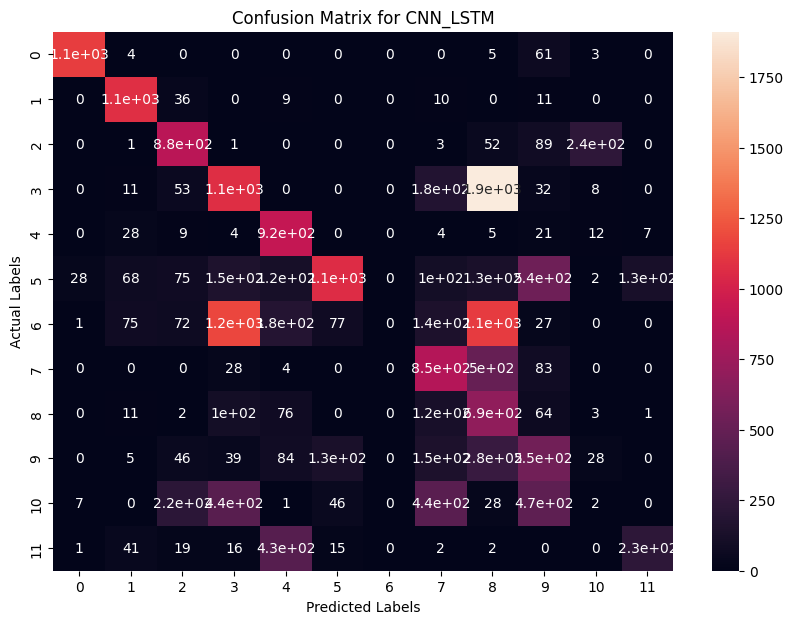

607/607 [==============================] - 1s 2ms/step
Classification Report for UNet:
              precision    recall  f1-score   support

           0       0.95      0.94      0.95      1208
           1       0.71      0.30      0.42      1147
           2       0.50      0.71      0.58      1258
           3       0.86      0.07      0.13      3262
           4       0.35      0.84      0.49      1011
           5       0.89      0.65      0.75      2408
           6       0.62      0.25      0.36      2881
           7       0.47      0.66      0.55      1466
           8       0.17      0.65      0.27      1064
           9       0.26      0.67      0.37      1313
          10       0.00      0.00      0.00      1649
          11       0.82      0.70      0.75       757

    accuracy                           0.45     19424
   macro avg       0.55      0.54      0.47     19424
weighted avg       0.59      0.45      0.43     19424



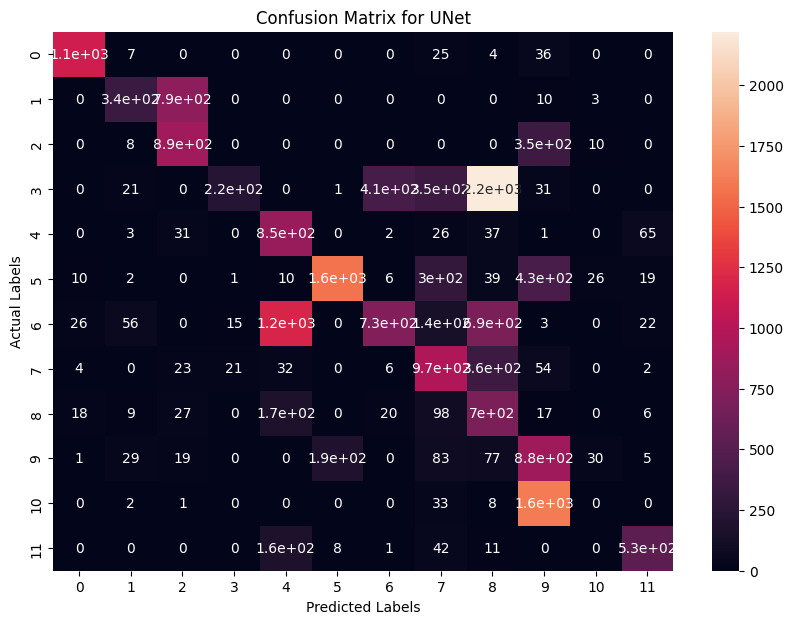

607/607 [==============================] - 2s 3ms/step
Classification Report for transformer_encoder:
              precision    recall  f1-score   support

           0       0.88      0.94      0.91      1208
           1       0.00      0.00      0.00      1147
           2       0.31      0.12      0.17      1258
           3       0.22      0.09      0.13      3262
           4       0.74      0.86      0.79      1011
           5       0.93      0.57      0.70      2408
           6       0.44      0.83      0.58      2881
           7       0.31      0.21      0.25      1466
           8       0.38      0.35      0.36      1064
           9       0.35      0.76      0.48      1313
          10       0.17      0.21      0.19      1649
          11       0.94      0.48      0.63       757

    accuracy                           0.44     19424
   macro avg       0.47      0.45      0.43     19424
weighted avg       0.45      0.44      0.42     19424



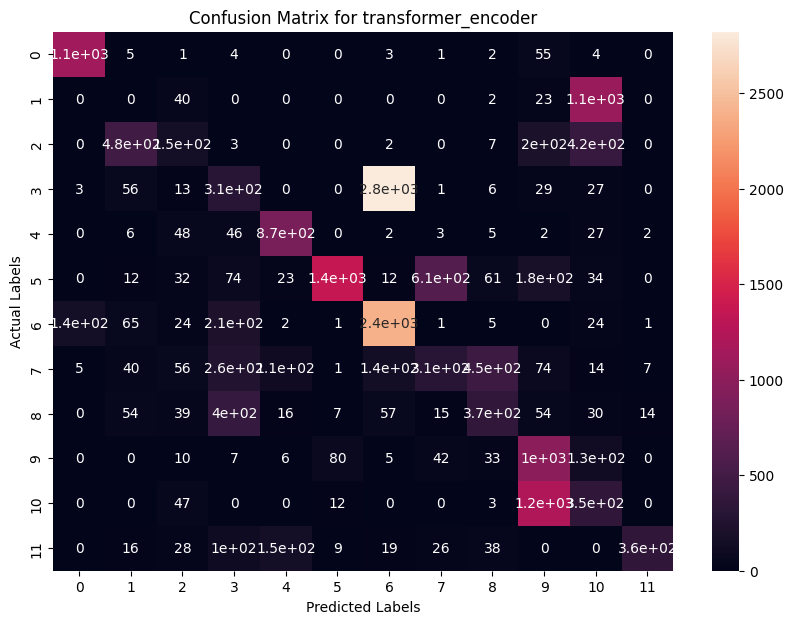

In [58]:
# draw confusion matrix, print the report

plot_classification_report_confusion_matrix(trained_models, X_test_seq, y_test_seq)

-----

### rotation

In [59]:
print (X_train.shape)

X_augmented, y_augmented = augment_and_split_by_activity(X_train, y_train, 
                                                         params=[np.pi / 4], aug_way='rotation', 
                                                         n_steps=100, hop=10)
X = np.vstack((X_train_seq, X_augmented))
y = np.concatenate((y_train_seq, y_augmented))

print (X.shape, y.shape)

(1554297, 35)
(233027, 100, 35) (233027,)


In [60]:
# fit

histories_rotation, trained_models = activate_all_model(X, y, input_shape, n_classes)

CNN_LSTM model parameters: 107228
UNet model parameters: 164572
Transformer Encoder model parameters: 114934
ERROR: Could not find file /tmp/ipykernel_37619/2750405356.py
model 0 running
epoch 1 completed : 27.13 seconds
epoch 2 completed : 8.73 seconds
epoch 3 completed : 8.62 seconds
epoch 4 completed : 8.54 seconds
epoch 5 completed : 8.71 seconds
epoch 6 completed : 8.61 seconds
epoch 7 completed : 8.86 seconds
epoch 8 completed : 8.83 seconds
epoch 9 completed : 8.64 seconds
epoch 10 completed : 8.61 seconds
epoch 11 completed : 8.78 seconds
epoch 12 completed : 8.56 seconds
epoch 13 completed : 8.76 seconds
epoch 14 completed : 8.64 seconds
epoch 15 completed : 9.02 seconds
epoch 16 completed : 8.88 seconds
epoch 17 completed : 8.60 seconds
epoch 18 completed : 8.72 seconds
epoch 19 completed : 8.90 seconds
epoch 20 completed : 8.68 seconds
epoch 21 completed : 8.91 seconds
epoch 22 completed : 8.87 seconds
epoch 23 completed : 8.61 seconds
epoch 24 completed : 8.67 seconds
epoch

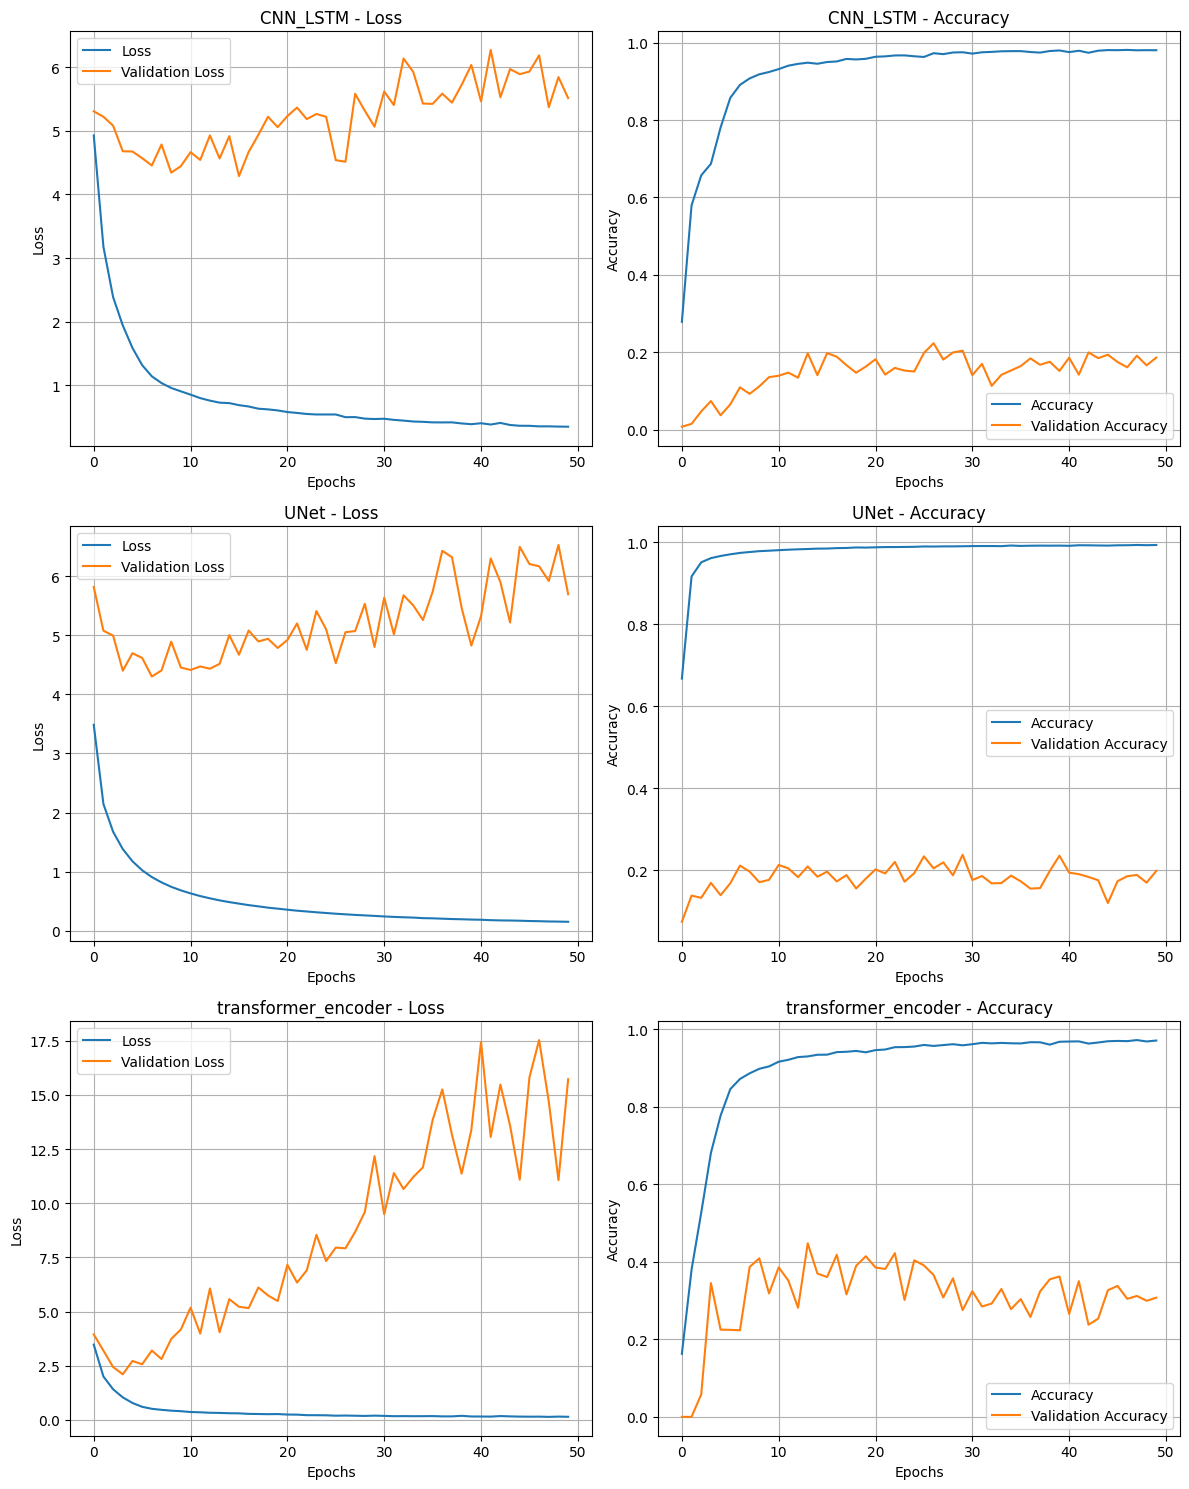

In [61]:
# draw loss, val_loss, acc, val_acc

draw_history(histories_rotation)

In [62]:
# evaluate

evaluation_rotation = extract_train_test_scores(trained_models, X, y,
                                                 X_test_seq, y_test_seq)
print (evaluation_rotation)

{'CNN_LSTM': {'train_score': [1.3261367082595825, 0.8323498964309692], 'test_score': [3.1222167015075684, 0.5123558640480042]}, 'UNet': {'train_score': [1.2621439695358276, 0.832706093788147], 'test_score': [4.512362480163574, 0.4268430769443512]}, 'transformer_encoder': {'train_score': [3.7190699577331543, 0.7227960824966431], 'test_score': [3.152147054672241, 0.5385090708732605]}}


In [63]:
# get accuracy, precision, recall, F1 score

performances_rotation = extract_performance_metrics(trained_models, X_test_seq, y_test_seq)
print (performances_rotation)

607/607 [==============================] - 2s 3ms/step
{'CNN_LSTM': {'accuracy': 0.5123558484349259, 'precision': 0.5252025709390903, 'recall': 0.5123558484349259, 'f1_score': 0.4922438476744933}, 'UNet': {'accuracy': 0.4268430807248764, 'precision': 0.4888743939061795, 'recall': 0.4268430807248764, 'f1_score': 0.40554967658020735}, 'transformer_encoder': {'accuracy': 0.538509060955519, 'precision': 0.5958896819171648, 'recall': 0.538509060955519, 'f1_score': 0.5410932405811866}}


607/607 [==============================] - 3s 5ms/step
Classification Report for CNN_LSTM:
              precision    recall  f1-score   support

           0       0.07      0.04      0.05      1208
           1       0.46      0.96      0.62      1147
           2       0.73      0.51      0.60      1258
           3       0.68      0.61      0.65      3262
           4       0.41      0.83      0.54      1011
           5       0.79      0.56      0.65      2408
           6       0.64      0.46      0.53      2881
           7       0.60      0.56      0.58      1466
           8       0.30      0.58      0.40      1064
           9       0.34      0.70      0.46      1313
          10       0.09      0.01      0.01      1649
          11       0.67      0.40      0.50       757

    accuracy                           0.51     19424
   macro avg       0.48      0.52      0.47     19424
weighted avg       0.53      0.51      0.49     19424



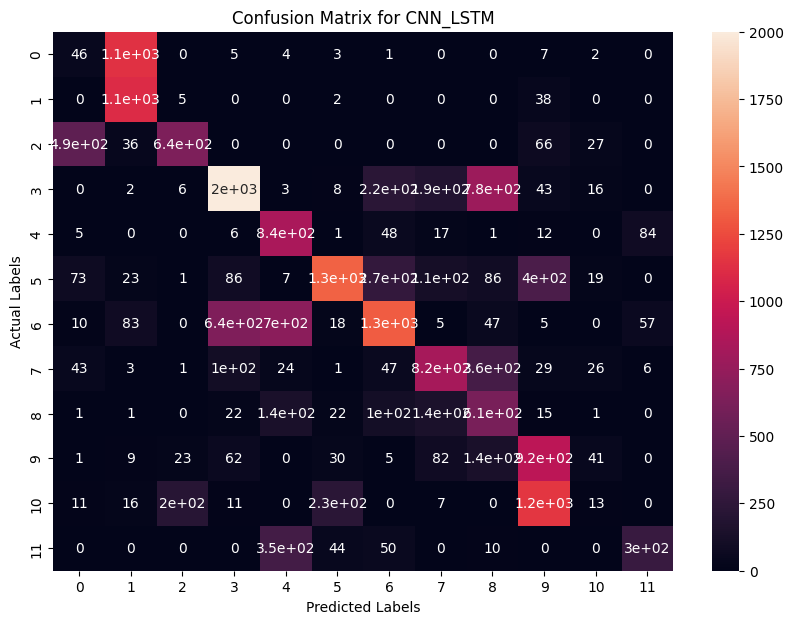

607/607 [==============================] - 1s 2ms/step
Classification Report for UNet:
              precision    recall  f1-score   support

           0       0.11      0.04      0.06      1208
           1       0.40      0.97      0.56      1147
           2       0.32      0.02      0.03      1258
           3       0.52      0.44      0.48      3262
           4       0.32      0.69      0.44      1011
           5       0.98      0.54      0.70      2408
           6       0.77      0.38      0.51      2881
           7       0.67      0.38      0.49      1466
           8       0.16      0.54      0.25      1064
           9       0.34      0.72      0.46      1313
          10       0.00      0.00      0.00      1649
          11       0.39      0.64      0.49       757

    accuracy                           0.43     19424
   macro avg       0.42      0.45      0.37     19424
weighted avg       0.49      0.43      0.41     19424



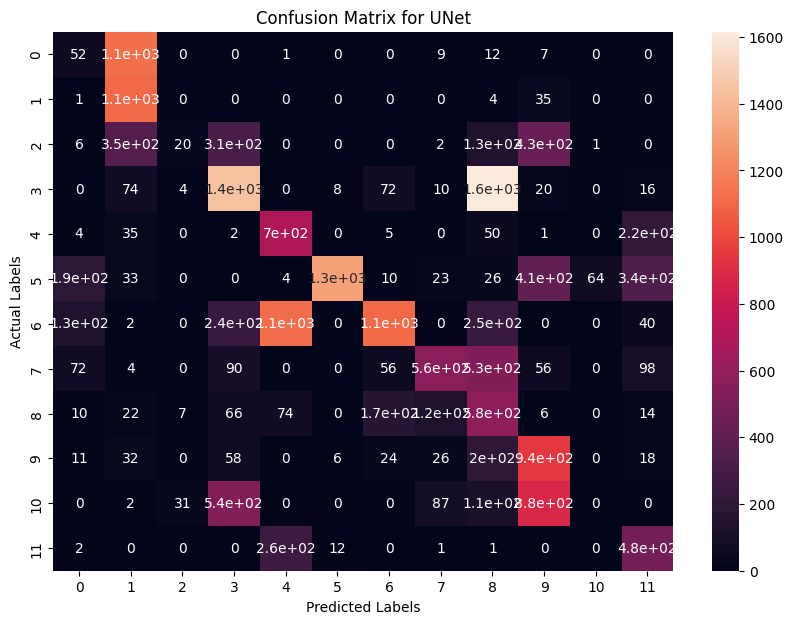

607/607 [==============================] - 2s 3ms/step
Classification Report for transformer_encoder:
              precision    recall  f1-score   support

           0       0.98      0.70      0.81      1208
           1       0.72      0.89      0.80      1147
           2       0.27      0.03      0.05      1258
           3       0.63      0.65      0.64      3262
           4       0.85      0.79      0.82      1011
           5       0.72      0.70      0.71      2408
           6       0.65      0.33      0.44      2881
           7       0.43      0.52      0.47      1466
           8       0.19      0.50      0.28      1064
           9       0.25      0.50      0.33      1313
          10       0.55      0.43      0.48      1649
          11       0.89      0.45      0.59       757

    accuracy                           0.54     19424
   macro avg       0.59      0.54      0.54     19424
weighted avg       0.60      0.54      0.54     19424



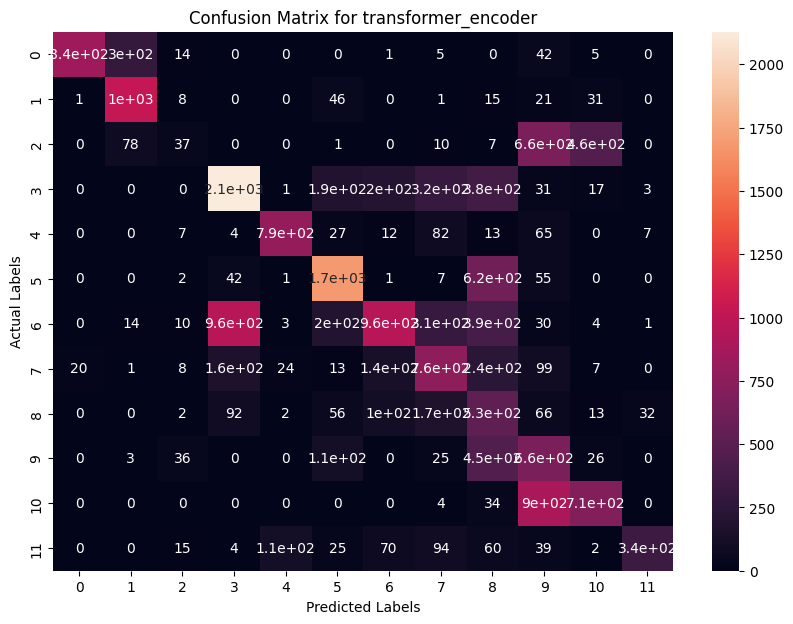

In [64]:
# draw confusion matrix, print the report

plot_classification_report_confusion_matrix(trained_models, X_test_seq, y_test_seq)

-----

### rand_sampling

In [65]:
X_augmented, y_augmented = augment_and_split_by_activity(X_train, y_train, 
                                                         params=[X_train.shape[0]], 
                                                         aug_way='rand_sampling', 
                                                         n_steps=100, hop=10)
X = np.vstack((X_train_seq, X_augmented))
y = np.concatenate((y_train_seq, y_augmented))

print (X.shape, y.shape)

(233027, 100, 35) (233027,)


In [66]:
# fit

histories_rand_sampling, trained_models = activate_all_model(X, y, input_shape, n_classes)

CNN_LSTM model parameters: 107228
UNet model parameters: 164572
Transformer Encoder model parameters: 114934
ERROR: Could not find file /tmp/ipykernel_37619/2750405356.py
model 0 running
epoch 1 completed : 27.39 seconds
epoch 2 completed : 8.66 seconds
epoch 3 completed : 8.77 seconds
epoch 4 completed : 8.79 seconds
epoch 5 completed : 8.69 seconds
epoch 6 completed : 8.80 seconds
epoch 7 completed : 8.79 seconds
epoch 8 completed : 8.68 seconds
epoch 9 completed : 8.74 seconds
epoch 10 completed : 8.65 seconds
epoch 11 completed : 8.78 seconds
epoch 12 completed : 8.59 seconds
epoch 13 completed : 8.53 seconds
epoch 14 completed : 8.81 seconds
epoch 15 completed : 8.78 seconds
epoch 16 completed : 8.61 seconds
epoch 17 completed : 8.87 seconds
epoch 18 completed : 8.92 seconds
epoch 19 completed : 8.63 seconds
epoch 20 completed : 8.78 seconds
epoch 21 completed : 8.72 seconds
epoch 22 completed : 9.01 seconds
epoch 23 completed : 8.78 seconds
epoch 24 completed : 8.77 seconds
epoch

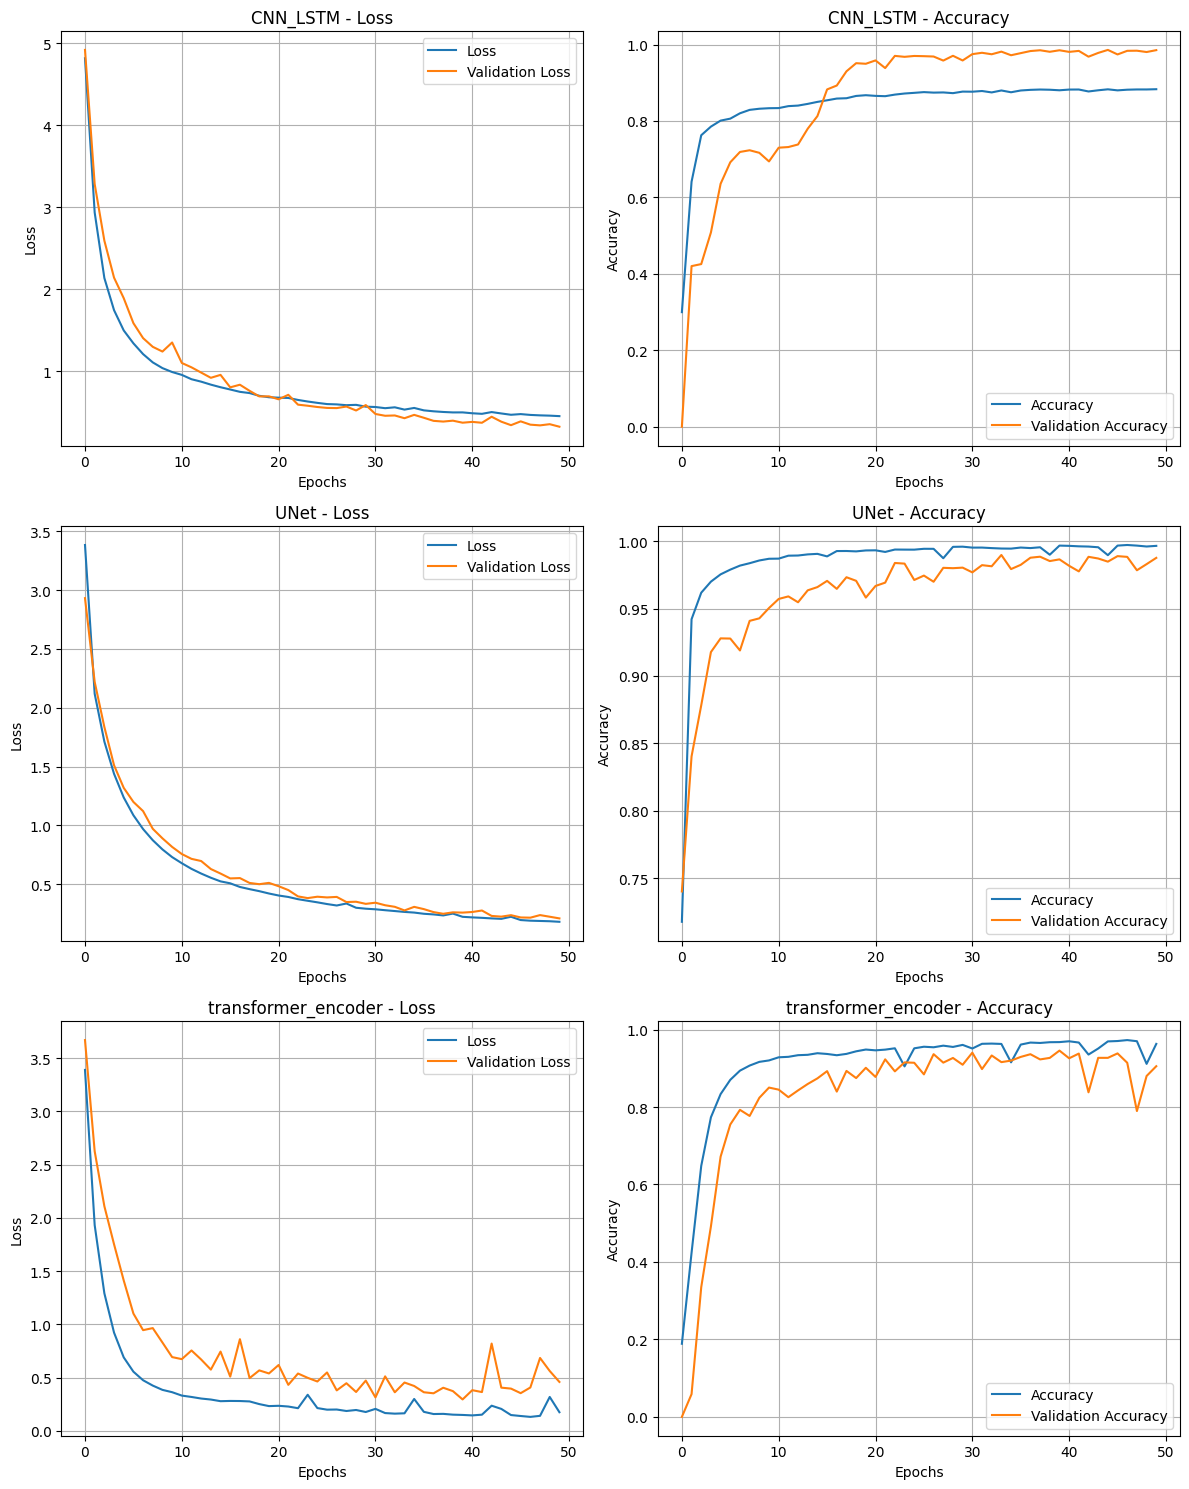

In [67]:
# draw loss, val_loss, acc, val_acc

draw_history(histories_rand_sampling)

In [68]:
# evaluate

evaluation_rand_sampling = extract_train_test_scores(trained_models, X, y,
                                                 X_test_seq, y_test_seq)
print (evaluation_rand_sampling)

{'CNN_LSTM': {'train_score': [0.38818201422691345, 0.9099761247634888], 'test_score': [2.6619319915771484, 0.5720242857933044]}, 'UNet': {'train_score': [0.18389078974723816, 0.9952451586723328], 'test_score': [4.596194744110107, 0.41191309690475464]}, 'transformer_encoder': {'train_score': [0.8352164030075073, 0.8385981321334839], 'test_score': [4.421834945678711, 0.47431012988090515]}}


In [70]:
# get accuracy, precision, recall, F1 score

performances_rand_sampling = extract_performance_metrics(trained_models, X_test_seq, y_test_seq)
print (performances_rand_sampling)

607/607 [==============================] - 2s 3ms/step
{'CNN_LSTM': {'accuracy': 0.5720242998352554, 'precision': 0.4879413016488302, 'recall': 0.5720242998352554, 'f1_score': 0.511969720686729}, 'UNet': {'accuracy': 0.411913097199341, 'precision': 0.3824520036314447, 'recall': 0.411913097199341, 'f1_score': 0.35383253090280326}, 'transformer_encoder': {'accuracy': 0.4743101317957166, 'precision': 0.5189149474429189, 'recall': 0.4743101317957166, 'f1_score': 0.47432966456832926}}


607/607 [==============================] - 3s 5ms/step
Classification Report for CNN_LSTM:
              precision    recall  f1-score   support

           0       0.78      0.94      0.85      1208
           1       0.89      0.82      0.86      1147
           2       0.68      0.46      0.55      1258
           3       0.51      0.86      0.65      3262
           4       0.64      0.78      0.70      1011
           5       0.90      0.96      0.93      2408
           6       0.00      0.00      0.00      2881
           7       0.72      0.50      0.59      1466
           8       0.17      0.28      0.21      1064
           9       0.30      0.72      0.42      1313
          10       0.00      0.00      0.00      1649
          11       0.71      0.74      0.73       757

    accuracy                           0.57     19424
   macro avg       0.53      0.59      0.54     19424
weighted avg       0.49      0.57      0.51     19424



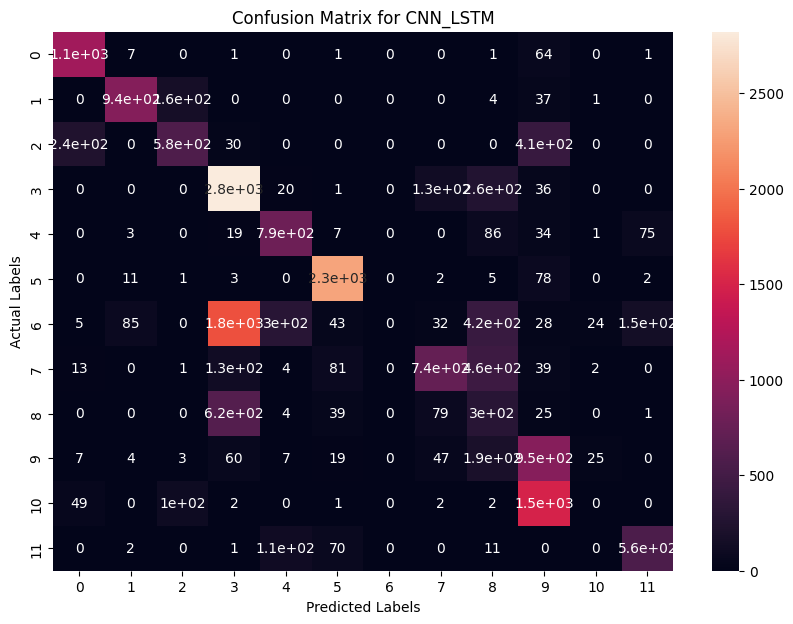

607/607 [==============================] - 1s 2ms/step
Classification Report for UNet:
              precision    recall  f1-score   support

           0       0.73      0.96      0.83      1208
           1       0.56      0.65      0.61      1147
           2       0.05      0.06      0.06      1258
           3       0.52      0.75      0.61      3262
           4       0.40      0.49      0.44      1011
           5       0.77      0.18      0.30      2408
           6       0.09      0.01      0.02      2881
           7       0.40      0.33      0.36      1466
           8       0.31      0.58      0.40      1064
           9       0.26      0.72      0.38      1313
          10       0.00      0.00      0.00      1649
          11       0.45      0.71      0.55       757

    accuracy                           0.41     19424
   macro avg       0.38      0.46      0.38     19424
weighted avg       0.38      0.41      0.35     19424



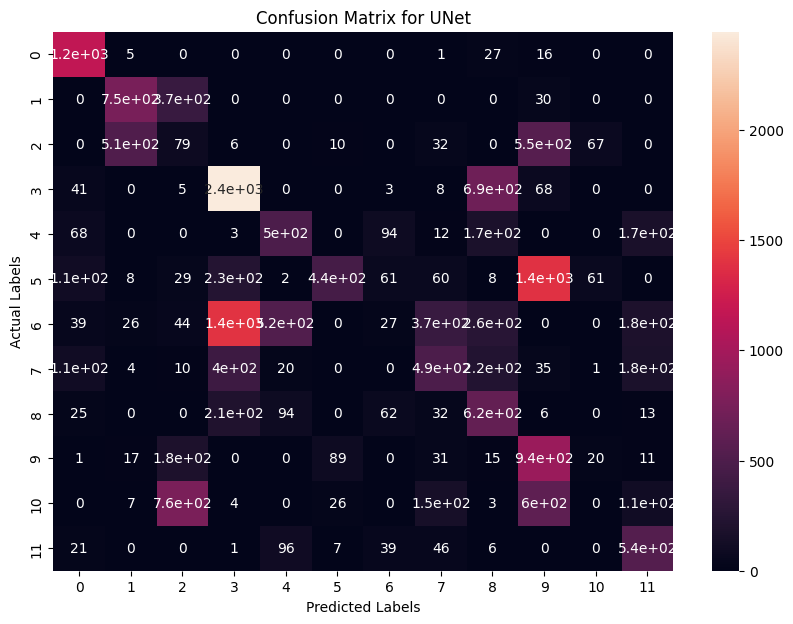

607/607 [==============================] - 2s 3ms/step
Classification Report for transformer_encoder:
              precision    recall  f1-score   support

           0       0.79      0.95      0.86      1208
           1       0.04      0.00      0.00      1147
           2       0.30      0.49      0.37      1258
           3       0.66      0.54      0.59      3262
           4       0.71      0.58      0.64      1011
           5       0.93      0.64      0.76      2408
           6       0.69      0.41      0.51      2881
           7       0.43      0.62      0.51      1466
           8       0.13      0.39      0.19      1064
           9       0.45      0.73      0.55      1313
          10       0.00      0.00      0.00      1649
          11       0.33      0.14      0.20       757

    accuracy                           0.47     19424
   macro avg       0.45      0.46      0.43     19424
weighted avg       0.52      0.47      0.47     19424



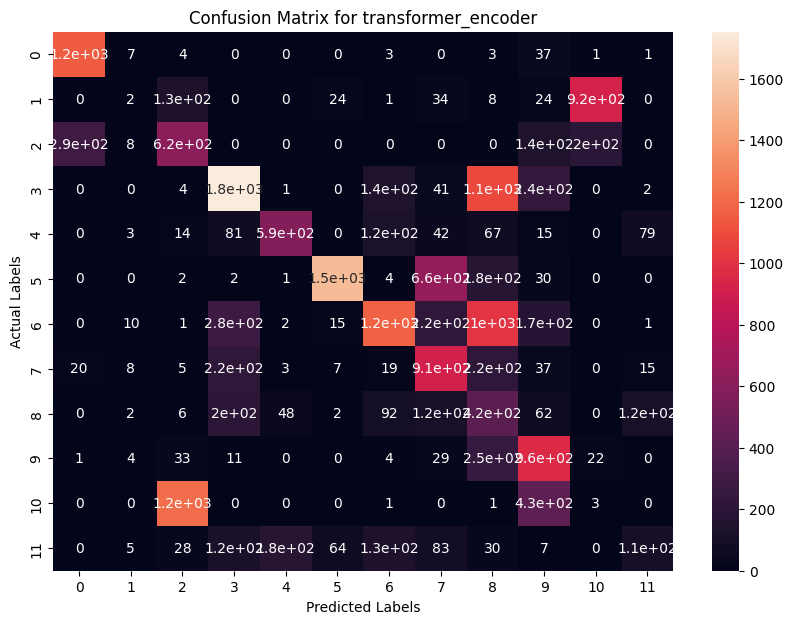

In [71]:
# draw confusion matrix, print the report

plot_classification_report_confusion_matrix(trained_models, X_test_seq, y_test_seq)